# Analyze sessions in batch from Phase 1 of AdaDrive (work in progress)

In [1]:
path_to_base_package = '../..'
import sys
# setting path
sys.path.append(f"{path_to_base_package}")

import matplotlib
# matplotlib.use('TkAgg')
import mne
mne.viz.set_3d_backend('pyvistaqt')

import json

import seaborn as sns
from IPython.display import display
from mna.utils.analysis import *
import matplotlib.pyplot as plt
from statannotations.Annotator import Annotator
from collections import defaultdict
import statsmodels as sm
from scipy.stats import spearmanr
%matplotlib inline
from mna.utils.data_access import * sdfs

Using pyvistaqt 3d backend.



# Aux functions, read files

In [3]:
output_dir = f"{path_to_base_package}/output/batch_analysis_motor/"
output_dir_non_baseline_non_average = f"{path_to_base_package}/output/batch_analysis_motor/saved_files_non_baseline_non_average/" # saved files directory (trial or motor)
remove_sessions = [(15,1),(22,1)]
rel_regions, all_region = get_relevant_channels()
rel_labels, rel_mappings = get_relevant_labels_mappings(path_to_base_package)
# reading the brodmann atlas mappings
# confirmed in freesurfer MNE template as mapping into these regions: http://www.brainm.com/software/pubs/dg/BA_10-20_ROI_Talairach/nearesteeg.htm
with open(f"{path_to_base_package}/data/annotated/brodmann_area_to_functional_name.json") as f:
    data = f.read()
brodmann_mappings = json.loads(data, object_hook=lambda d: {int(k) if k.isdigit() else k: v for k, v in d.items()})


pupil_df = pd.read_csv(f"{path_to_base_package}/output/pupil_exposure/participant_level_exposure_fits.csv")
trial_dfs = pd.read_csv(f"{output_dir}all_results.csv")
motor_dfs = read_motor_csvs(output_dir)
motor_dfs['post_steer_event_raw'] = motor_dfs['post_steer_event_raw'].apply(str_list_to_list)
motor_epochs = get_motor_epochs(output_dir_non_baseline_non_average)
#low_motor_sensor = motor_epochs["Steer_Wheel_Degree_Categorical == 'Low'"]
#high_motor_sensor = motor_epochs["Steer_Wheel_Degree_Categorical == 'High'"]
#low_pupil = motor_epochs["pupil_bin == '{}'".format('low')]
#high_pupil =motor_epochs["pupil_bin == '{}'".format('high')]
exposure_epochs = get_exposure_epochs(f"{path_to_base_package}/output/exposure/exposure_epochs.pickle")
#low_motor_sensor.apply_proj()
#high_motor_sensor.apply_proj()

p_val_criteria = 0.05
preturn = 1000

Reading labels from parcellation...


KeyError: 'Key "SUBJECTS_DIR" not found in the environment or in the the mne-python config file (/home/schko/.mne/mne-python.json). Try either os.environ["SUBJECTS_DIR"] = VALUE for a temporary solution, or mne.utils.set_config("SUBJECTS_DIR", VALUE, set_env=True) for a permanent one. You can also set the environment variable before running python.'

# Clean up dfs

In [3]:
# seaborn
import math 
sns.set(font_scale=1.2)
sns.set_palette("tab10")
from mna.utils.batch_feature_extraction import clean_up_adadrive_trials

motor_outlier_cols = ['abs_sum_delta_steer_input']
cols_to_outlier_detect = ['bpm', 'sdnn', 'rmssd', 'pnn50']
experimental_cols = ['spoken_difficulty', 'trial_duration', 'density', 'trial_damage']
eye_cols = ['Left Pupil Diameter', "NSLR_count_Fixation", "NSLR_count_Saccade",
            'NSLR_mean_duration_Fixation', 'NSLR_mean_duration_Saccade',
            'NSLR_first_onset_Fixation', 'NSLR_first_onset_Saccade']
ecg_cols = ['bpm', 'sdnn', 'rmssd', 'pnn50']  # rmssd = parasympathetic
motor_cols = ['abs_sum_delta_steer_input', 'abs_sum_delta_brake_input', 'abs_sum_delta_throttle_input']
def remove_motor_overlaps(test_df):
    test_df = test_df.reset_index(drop=True)
    trial_list = list(zip(test_df.trial_start_time, test_df.trial_end_time, test_df.index))
    overlaps = []
    for i in range(1,len(trial_list)):
        base_data = trial_list[i]
        check_data = trial_list[i-1]
        if base_data[1] > check_data[0] and base_data[1] <= check_data[1]:
            overlaps.append((base_data, check_data, base_data[1]-check_data[0], base_data[2], check_data[2]))
            assert base_data[1]-check_data[0] != 1, 'Major issue, repeating trials found. Double check'
    drop_rows = []
    for overlap in overlaps:
        row_1 = test_df.iloc[overlap[-1]]
        row_2 = test_df.iloc[overlap[-2]]
        if np.argmax([row_1.Abs_Steer_Wheel_Degree, row_2.Abs_Steer_Wheel_Degree]) == 0: # if row 1 has larger steer motion, drop the other
            drop_rows.append(overlap[-2])
        else:
            drop_rows.append(overlap[-1])
    test_df = test_df.drop(drop_rows,axis=0)
    return test_df

def clean_up_trials(input_df):
    all_dfs_final = clean_up_adadrive_trials(input_df.copy())
    # damage change
    all_dfs_final = all_dfs_final.sort_values(by=['ppid', 'session', 'block', 'trial'])
    # nan, outliers
    #for col in motor_outlier_cols:
    #    all_dfs_final[col] = all_dfs_final[col].mask(all_dfs_final[col].sub(all_dfs_final[col].mean()).div(all_dfs_final[col].std()).abs().gt(2))
    #all_dfs_final['abs_sum_delta_brake_input'] = all_dfs_final['abs_sum_delta_brake_input'].mask(all_dfs_final['abs_sum_delta_brake_input']>.1)

    all_dfs_final['NSLR_first_onset_Fixation'] = all_dfs_final['NSLR_first_onset_Fixation'] - all_dfs_final[
        'trial_start_time']
    all_dfs_final['NSLR_first_onset_Saccade'] = all_dfs_final['NSLR_first_onset_Saccade'] - all_dfs_final[
        'trial_start_time']

    all_dfs_final[
        'throttle_over_brake'] = all_dfs_final.abs_sum_delta_throttle_input / all_dfs_final.abs_sum_delta_brake_input
    return all_dfs_final


trial_dfs = clean_up_trials(trial_dfs)
trial_dfs = trial_dfs.loc[~trial_dfs.ppid_session.isin([f"{es[0]}_{es[1]}" for es in remove_sessions])]
motor_dfs = clean_up_trials(motor_dfs)
print(f"removing ovlerlapping motor trials, starting epoch count {len(motor_dfs)}")
motor_dfs = remove_motor_overlaps(motor_dfs)
print(f"post removal epoch count {len(motor_dfs)}")
# luminance effect removal from pupil diameter
trial_dfs['Raw Left Pupil Diameter'] = trial_dfs['Left Pupil Diameter']
motor_dfs['Raw Left Pupil Diameter'] = motor_dfs['Left Pupil Diameter']
trial_dfs = trial_dfs.reset_index(drop=True)
adjustments=[]
for index, row in trial_dfs.iloc[1:].iterrows():
    last_ppid = trial_dfs.iloc[index - 1].ppid
    last_session = trial_dfs.iloc[index - 1].session
    last_trial = trial_dfs.iloc[index - 1].trial
    last_opacity = trial_dfs.iloc[index - 1].density
    if ((row.ppid == last_ppid) & (row.session == last_session) & (row.trial == last_trial + 1)):  # if continuous
        # if there is a significant effect of opacity on pupil
        if pupil_df.loc[pupil_df['sub'] == last_ppid, 'p_opacities'].values < p_val_criteria:
            this_opacity = row.density
            this_pupil_diameter = row['Left Pupil Diameter']
            weight = pupil_df.loc[pupil_df['sub'] == last_ppid, 'w_opacities']
            adjustment = ((this_opacity - last_opacity) * weight).values[0]
            trial_dfs.iloc[index, trial_dfs.columns.get_loc('Left Pupil Diameter')] += adjustment
            # this needs to be converted to array b/c of pandas issues
            old_pupil_value = np.array(motor_dfs.loc[(motor_dfs.ppid == last_ppid) & (motor_dfs.session == last_session) & (
                        motor_dfs.trial == last_trial + 1), 'Left Pupil Diameter']) 
            motor_dfs.loc[(motor_dfs.ppid == last_ppid) & (motor_dfs.session == last_session) & (
                        motor_dfs.trial == last_trial + 1), 'Left Pupil Diameter'] = (old_pupil_value-adjustment).T  # update motor df too
            # do also for motor_epochs
            old_pupil_value = motor_epochs.metadata.loc[(motor_epochs.metadata.ppid == last_ppid) &
                                      (motor_epochs.metadata.session == last_session) &
                                      (motor_epochs.metadata.trial == last_trial + 1), 'Left Pupil Diameter']
            motor_epochs.metadata.loc[(motor_epochs.metadata.ppid == last_ppid) &
                                      (motor_epochs.metadata.session == last_session) &
                                      (motor_epochs.metadata.trial == last_trial + 1), 'Left Pupil Diameter'] = (old_pupil_value-adjustment).T
# pupil bins
motor_dfs['pupil_bin'] = motor_dfs.groupby(['ppid'])['Left Pupil Diameter'].transform(
    lambda x: pd.qcut(x, 2, labels=['low', 'high']))
trial_dfs['pupil_bin'] = trial_dfs.groupby(['ppid'])['Left Pupil Diameter'].transform(
    lambda x: pd.qcut(x, 2, labels=['low', 'high']))
motor_epochs.metadata['pupil_bin'] = motor_epochs.metadata.groupby(['ppid'])['Left Pupil Diameter'].transform(
    lambda x: pd.qcut(x, 2, labels=['low', 'high']))
motor_dfs['pupil_bin_encoded'] = motor_dfs.groupby(['ppid'])['Left Pupil Diameter'].transform(
    lambda x: pd.qcut(x, 2, labels=[0, 1]))
trial_dfs['pupil_bin_encoded'] = trial_dfs.groupby(['ppid'])['Left Pupil Diameter'].transform(
    lambda x: pd.qcut(x, 2, labels=[0, 1]))
motor_epochs.metadata['pupil_bin_encoded'] = motor_epochs.metadata.groupby(['ppid'])['Left Pupil Diameter'].transform(
    lambda x: pd.qcut(x, 2, labels=[0, 1]))


# participant-level binning of motor data, replaces the session-level info already there
motor_dfs = get_motor_intensity_info(motor_dfs)
motor_epochs.metadata = get_motor_intensity_info(motor_epochs.metadata)


# ensure that epochs that removed from motor epochs are also removed from EEG analysis (we don't do the reverse since we have non-eeg, usable data)
df_all = motor_epochs.metadata[['ppid', 'session', 'block', 'trial']].merge(motor_dfs[['ppid', 'session', 'block', 'trial']].drop_duplicates(), on=['ppid', 'session', 'block', 'trial'], 
                   how='inner', indicator=True)
i1 = motor_epochs.metadata.set_index(['ppid', 'session', 'block', 'trial']).index
i2 = df_all.set_index(['ppid', 'session', 'block', 'trial']).index
motor_epochs = motor_epochs[i1.isin(i2)]
# motor_epochs.set_eeg_reference('average') # custom eeg reference is not allowed for MNE source modeling
motor_epochs.apply_baseline((-((preturn+250) / 1000), -((preturn) / 1000)))

print(pupil_df[['sub','w_opacities','const','p_opacities']].to_latex(index=False,float_format="{:0.2f}".format))

removing ovlerlapping motor trials, starting epoch count 6291
post removal epoch count 6218
Replacing existing metadata with 75 columns
Applying baseline correction (mode: mean)
\begin{tabular}{rrrr}
\toprule
 sub &  w\_opacities &  const &  p\_opacities \\
\midrule
  20 &        -0.63 &   0.80 &         0.00 \\
  14 &        -0.15 &   0.24 &         0.00 \\
  12 &        -1.06 &   0.96 &         0.00 \\
  22 &        -1.18 &   1.33 &         0.00 \\
  16 &        -0.27 &   0.37 &         0.00 \\
  18 &        -1.23 &   0.98 &         0.00 \\
  19 &         0.34 &  -0.13 &         0.00 \\
  21 &        -0.44 &   0.46 &         0.00 \\
  15 &        -3.06 &   2.15 &         0.00 \\
  13 &        -1.11 &   1.13 &         0.00 \\
  23 &        -0.55 &   0.58 &         0.00 \\
  17 &        -0.60 &   0.45 &         0.00 \\
\bottomrule
\end{tabular}



## Evoked data by motor intensity

In [4]:
if os.path.isfile(f"{output_dir_non_baseline_non_average}source_time_courses.pickle"):
    all_tcs = pickle.load(open(f"{output_dir_non_baseline_non_average}source_time_courses.pickle", 'rb'))
    all_tcs = np.concatenate(all_tcs)
    assert len(all_tcs) == len(motor_epochs), 'the source data is not the same size as the motor_epochs, check this issue'
else:
    print('need to export source, time courses')



In [5]:
from mne_features.univariate import compute_pow_freq_bands
bands = [4, 8, 15, 32, 55]
band_intervals = list(zip(bands[:-1], bands[1:]))
eeg_channel_names = []
for i in range(len(rel_labels)):
    eeg_channel_names.append(f"{rel_mappings[rel_labels[i].name]}_{rel_labels[i].hemi}")
channel_band_power = [f"{chan_name}_{each_band[0]}-{each_band[1]}_Hz_Power"
                              for chan_name in eeg_channel_names
                                  for each_band in band_intervals]
band_power_all = np.empty([len(all_tcs), len(eeg_channel_names)*len(band_intervals)])
for i in range(len(all_tcs)):
    eeg_data = all_tcs[i,:]
    # Multitaper Method
    band_power = compute_pow_freq_bands(sfreq=128, data=eeg_data, freq_bands=band_intervals, normalize=True,
                                        psd_method = 'multitaper')
    band_power_all[i, :] = band_power
bpower_df = pd.DataFrame(band_power_all)
bpower_df.columns=channel_band_power
motor_epochs_metadata = motor_epochs.metadata.reset_index(drop=True)
motor_epochs_metadata = pd.concat([motor_epochs_metadata,bpower_df],axis=1)

# Trial data accuracy

size of dataset (477, 15) lost 478 trials or 0.5005235602094241 as a result of removing nan values given the predictors
Class 1 proportion in training dataset 0.5546218487394958
Test AUC: 0.5432232170422969 Accuracy: 0.5666666666666667
Elapsed time to compute the importances: 0.004 seconds
Elapsed time to compute the importances: 6.176 seconds


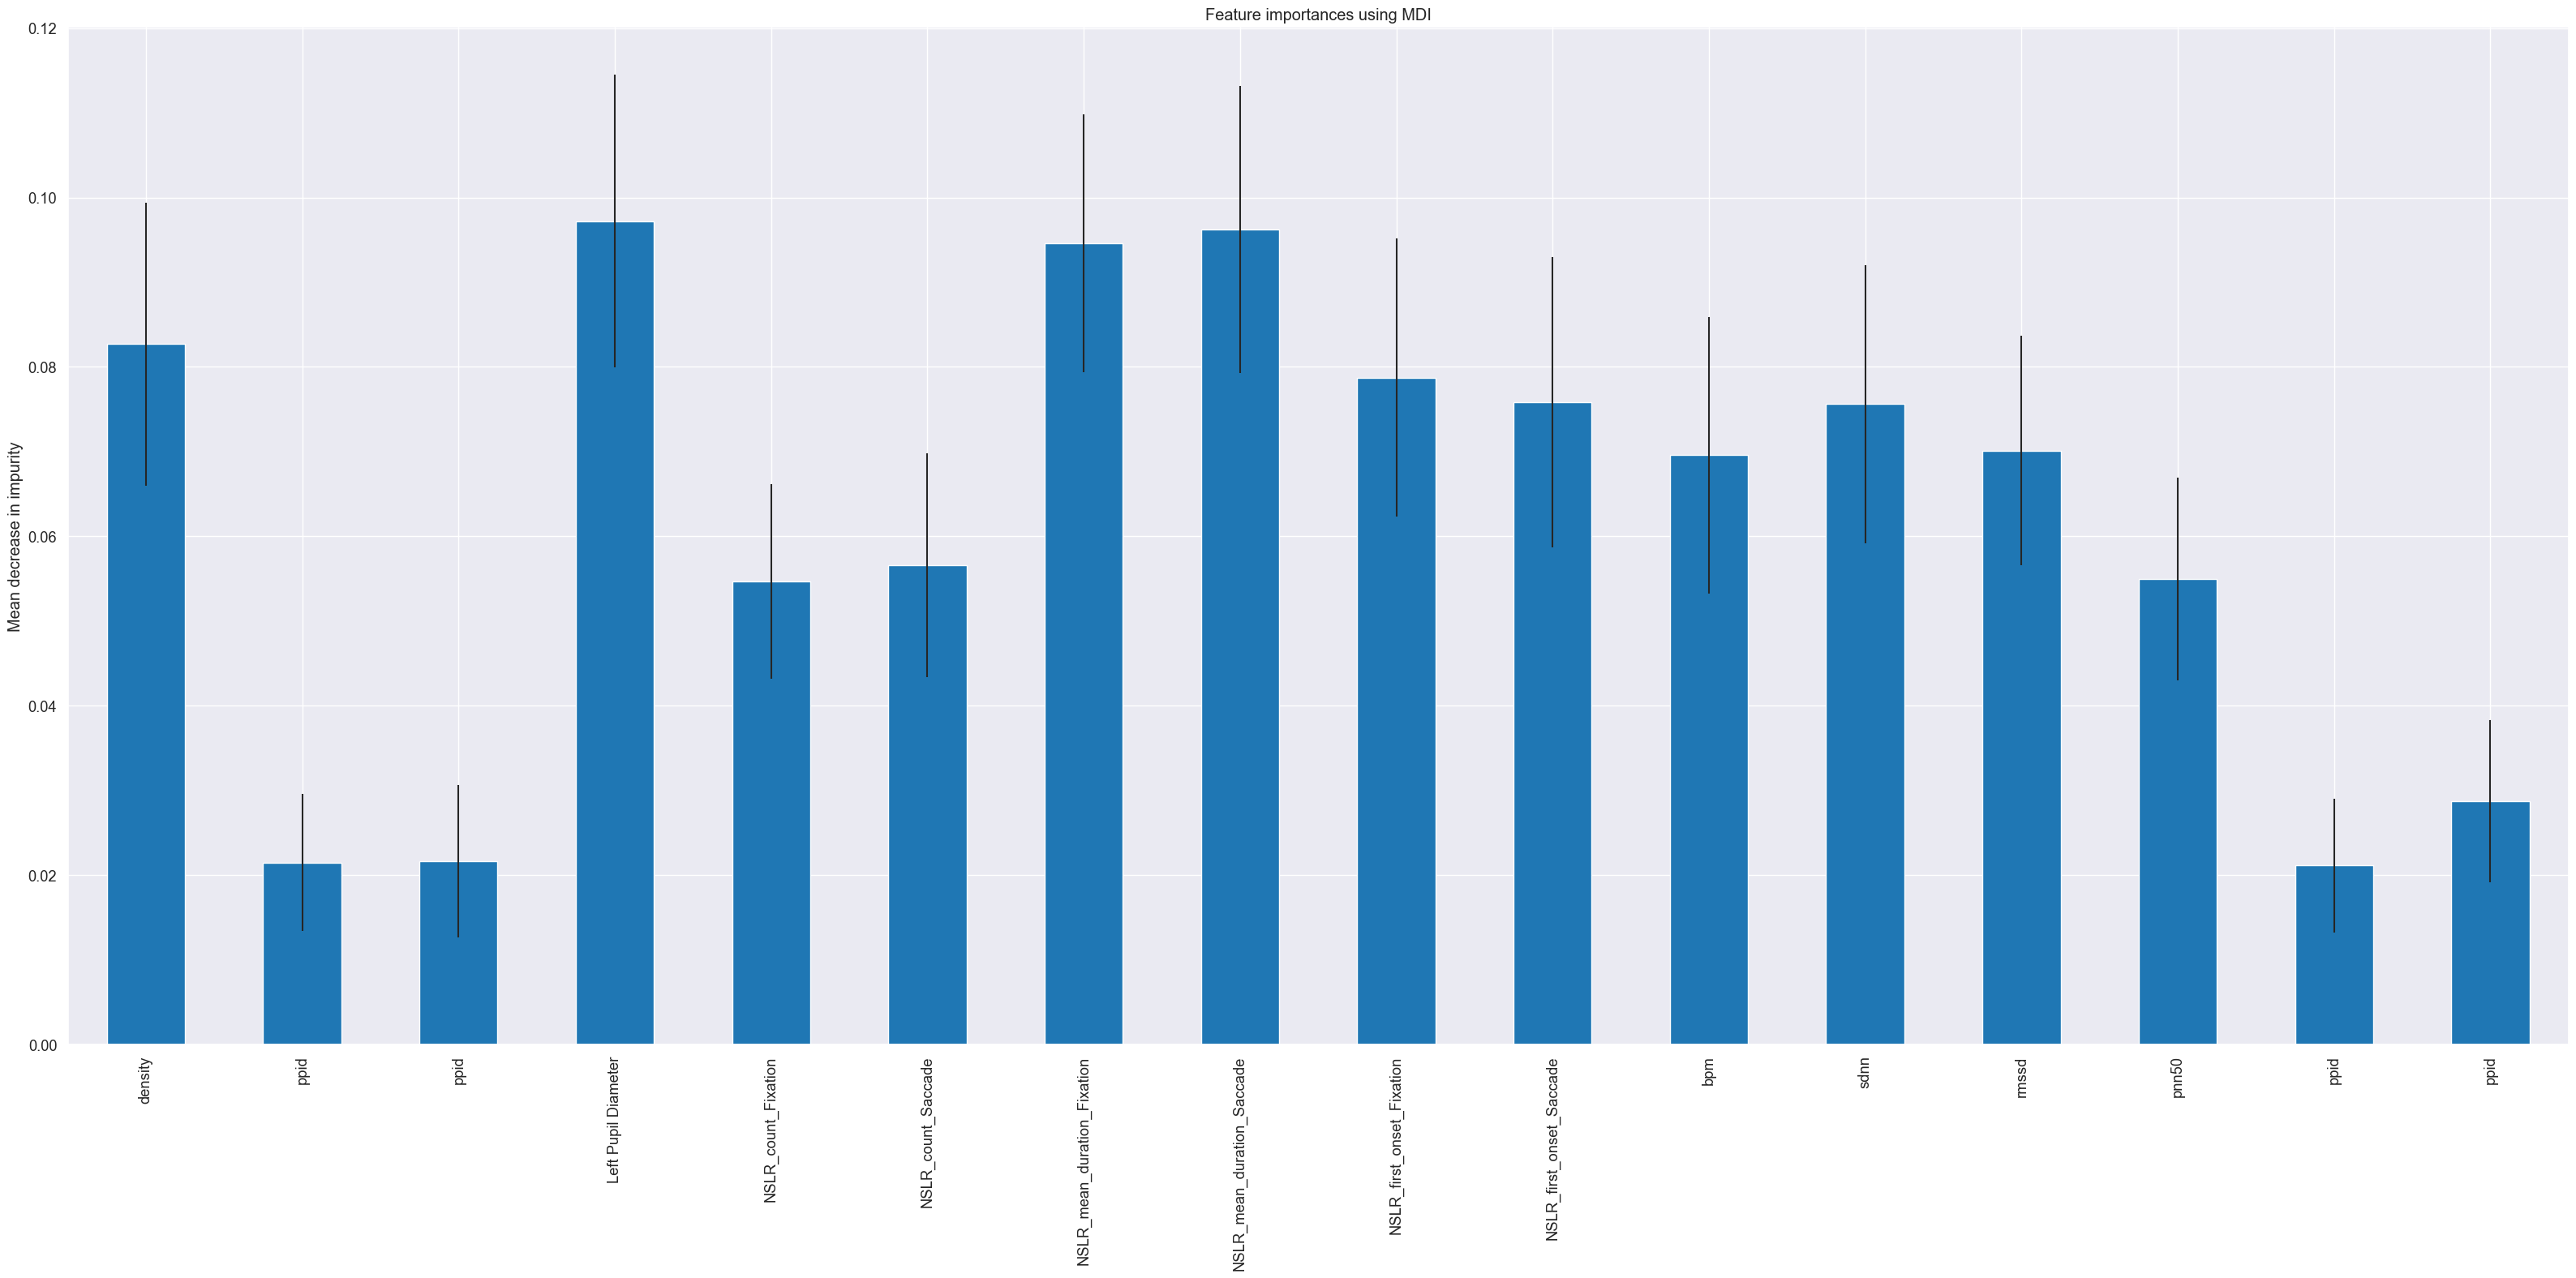

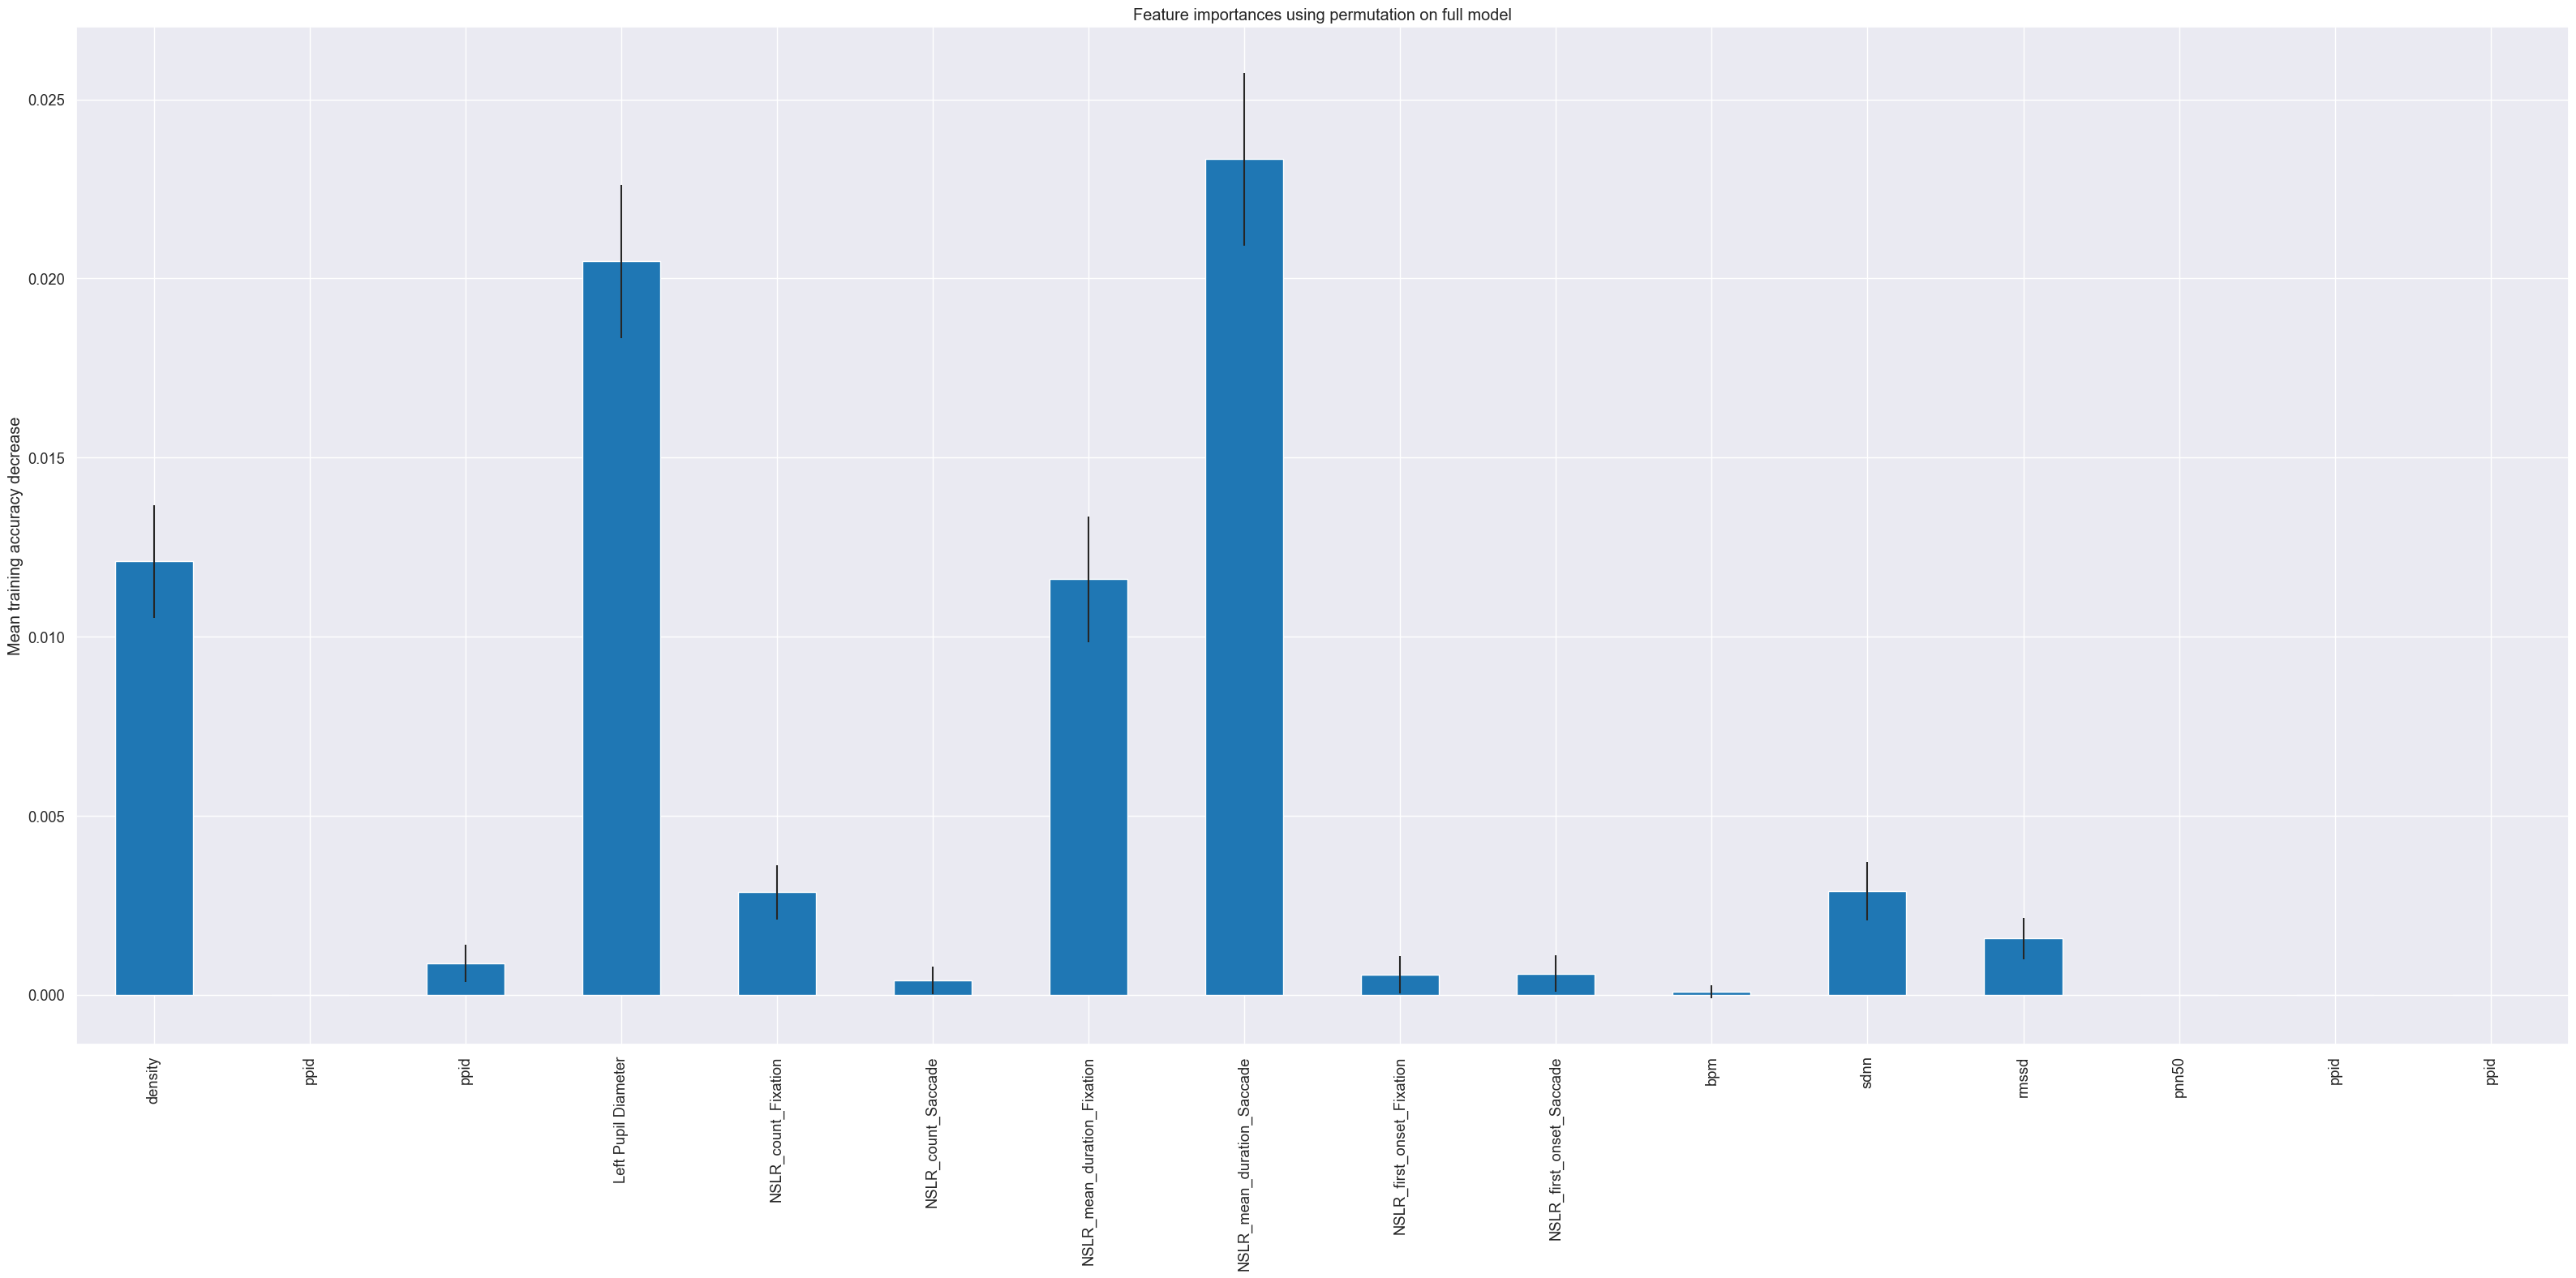

In [6]:
from sklearn.inspection import permutation_importance
import scipy.stats as st
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import time
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score, r2_score

def rf_prediction_importances(input_df, prediction, predictors,pred_type = 'classification', calc_importances=True, seed=None, plot=True):
    prediction = prediction
    predictors = predictors

    # drop na
    motor_dfs_nonnan = input_df[predictors+[prediction]].dropna()
    print(f"size of dataset {motor_dfs_nonnan.shape} lost {len(input_df)-len(motor_dfs_nonnan)} trials or {(len(input_df)-len(motor_dfs_nonnan))/len(input_df)} as a result of removing nan values given the predictors")

    y = motor_dfs_nonnan[prediction]
    X = motor_dfs_nonnan[predictors]
    X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=seed)
    feature_names = list(X.columns)
    if pred_type == 'classification':
        forest = RandomForestClassifier(random_state=seed)
    elif pred_type == 'regression':
        forest = RandomForestRegressor(random_state=seed)
    forest.fit(X_train, y_train)

    # results
    if pred_type == 'classification':
        print(f"Class 1 proportion in training dataset {(y_train==1).sum()/len(y_train)}")
        print(f"Test AUC: {roc_auc_score(y_test, forest.predict_proba(X_test)[:,1])} Accuracy: {accuracy_score(y_test, forest.predict(X_test))}")
    elif pred_type == 'regression':
        print(f"Test R2: {r2_score(y_test, forest.predict(X_test))}")
    # importances
    if calc_importances:
        start_time = time.time()
        importances = forest.feature_importances_
        data = [tree.feature_importances_ for tree in forest.estimators_]
        cis = st.t.interval(alpha=0.95, df=len(data)-1, loc=np.mean(data,axis=0), scale=st.sem(data))
        std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
        elapsed_time = time.time() - start_time

        print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")
        forest_importances = pd.Series(importances, index=feature_names)
        if plot:
            fig, ax = plt.subplots(figsize=(32,16))
            forest_importances.plot.bar(yerr=cis[1]-cis[0], ax=ax)
            ax.set_title("Feature importances using MDI")
            ax.set_ylabel("Mean decrease in impurity")
            fig.tight_layout()

    if calc_importances:
        start_time = time.time()
        result = permutation_importance(
            forest, X_train, y_train, n_repeats=100, random_state=seed, n_jobs=2 # using training set
        )
        elapsed_time = time.time() - start_time
        print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")
        data = result.importances.T
        cis = st.t.interval(alpha=0.95, df=len(data)-1, loc=np.mean(data,axis=0), scale=st.sem(data))

        forest_importances = pd.Series(result.importances_mean, index=feature_names)
        forest_importances = np.clip(forest_importances,0,None) # clip the importances at 0 minimum so it makes sense, only relevant for small DFs
        if plot:
            fig, ax = plt.subplots(figsize=(32,16))
            forest_importances.plot.bar(yerr=cis[1]-cis[0], ax=ax)
            ax.set_title("Feature importances using permutation on full model")
            if pred_type == 'classification':
                ax.set_ylabel("Mean training accuracy decrease")
            elif pred_type == 'regression':
                ax.set_ylabel("Mean training R2 decrease")
            fig.tight_layout()
            plt.show()

prediction = 'spoken_difficulty_encoded'
predictors = ['density', 'ppid','Left Pupil Diameter', 'NSLR_count_Fixation', 'NSLR_count_Saccade',
       'NSLR_mean_duration_Fixation', 'NSLR_mean_duration_Saccade', 'NSLR_first_onset_Fixation',
       'NSLR_first_onset_Saccade', 'bpm', 'sdnn', 'rmssd', 'pnn50', 'ppid']

# filter rows
trial_dfs_filtered = trial_dfs.copy()
trial_dfs_filtered = trial_dfs_filtered[trial_dfs_filtered.spoken_difficulty != 'unknown']

rf_prediction_importances(trial_dfs_filtered, prediction, predictors, seed=42, calc_importances=True, plot=True)

# Feature importances

size of dataset (2598, 22) lost 88 trials or 0.03276247207743857 as a result of removing nan values given the predictors
Class 1 proportion in training dataset 0.5112936344969199
Test AUC: 0.5306409223449969 Accuracy: 0.5323076923076923
Elapsed time to compute the importances: 0.005 seconds
Elapsed time to compute the importances: 23.192 seconds


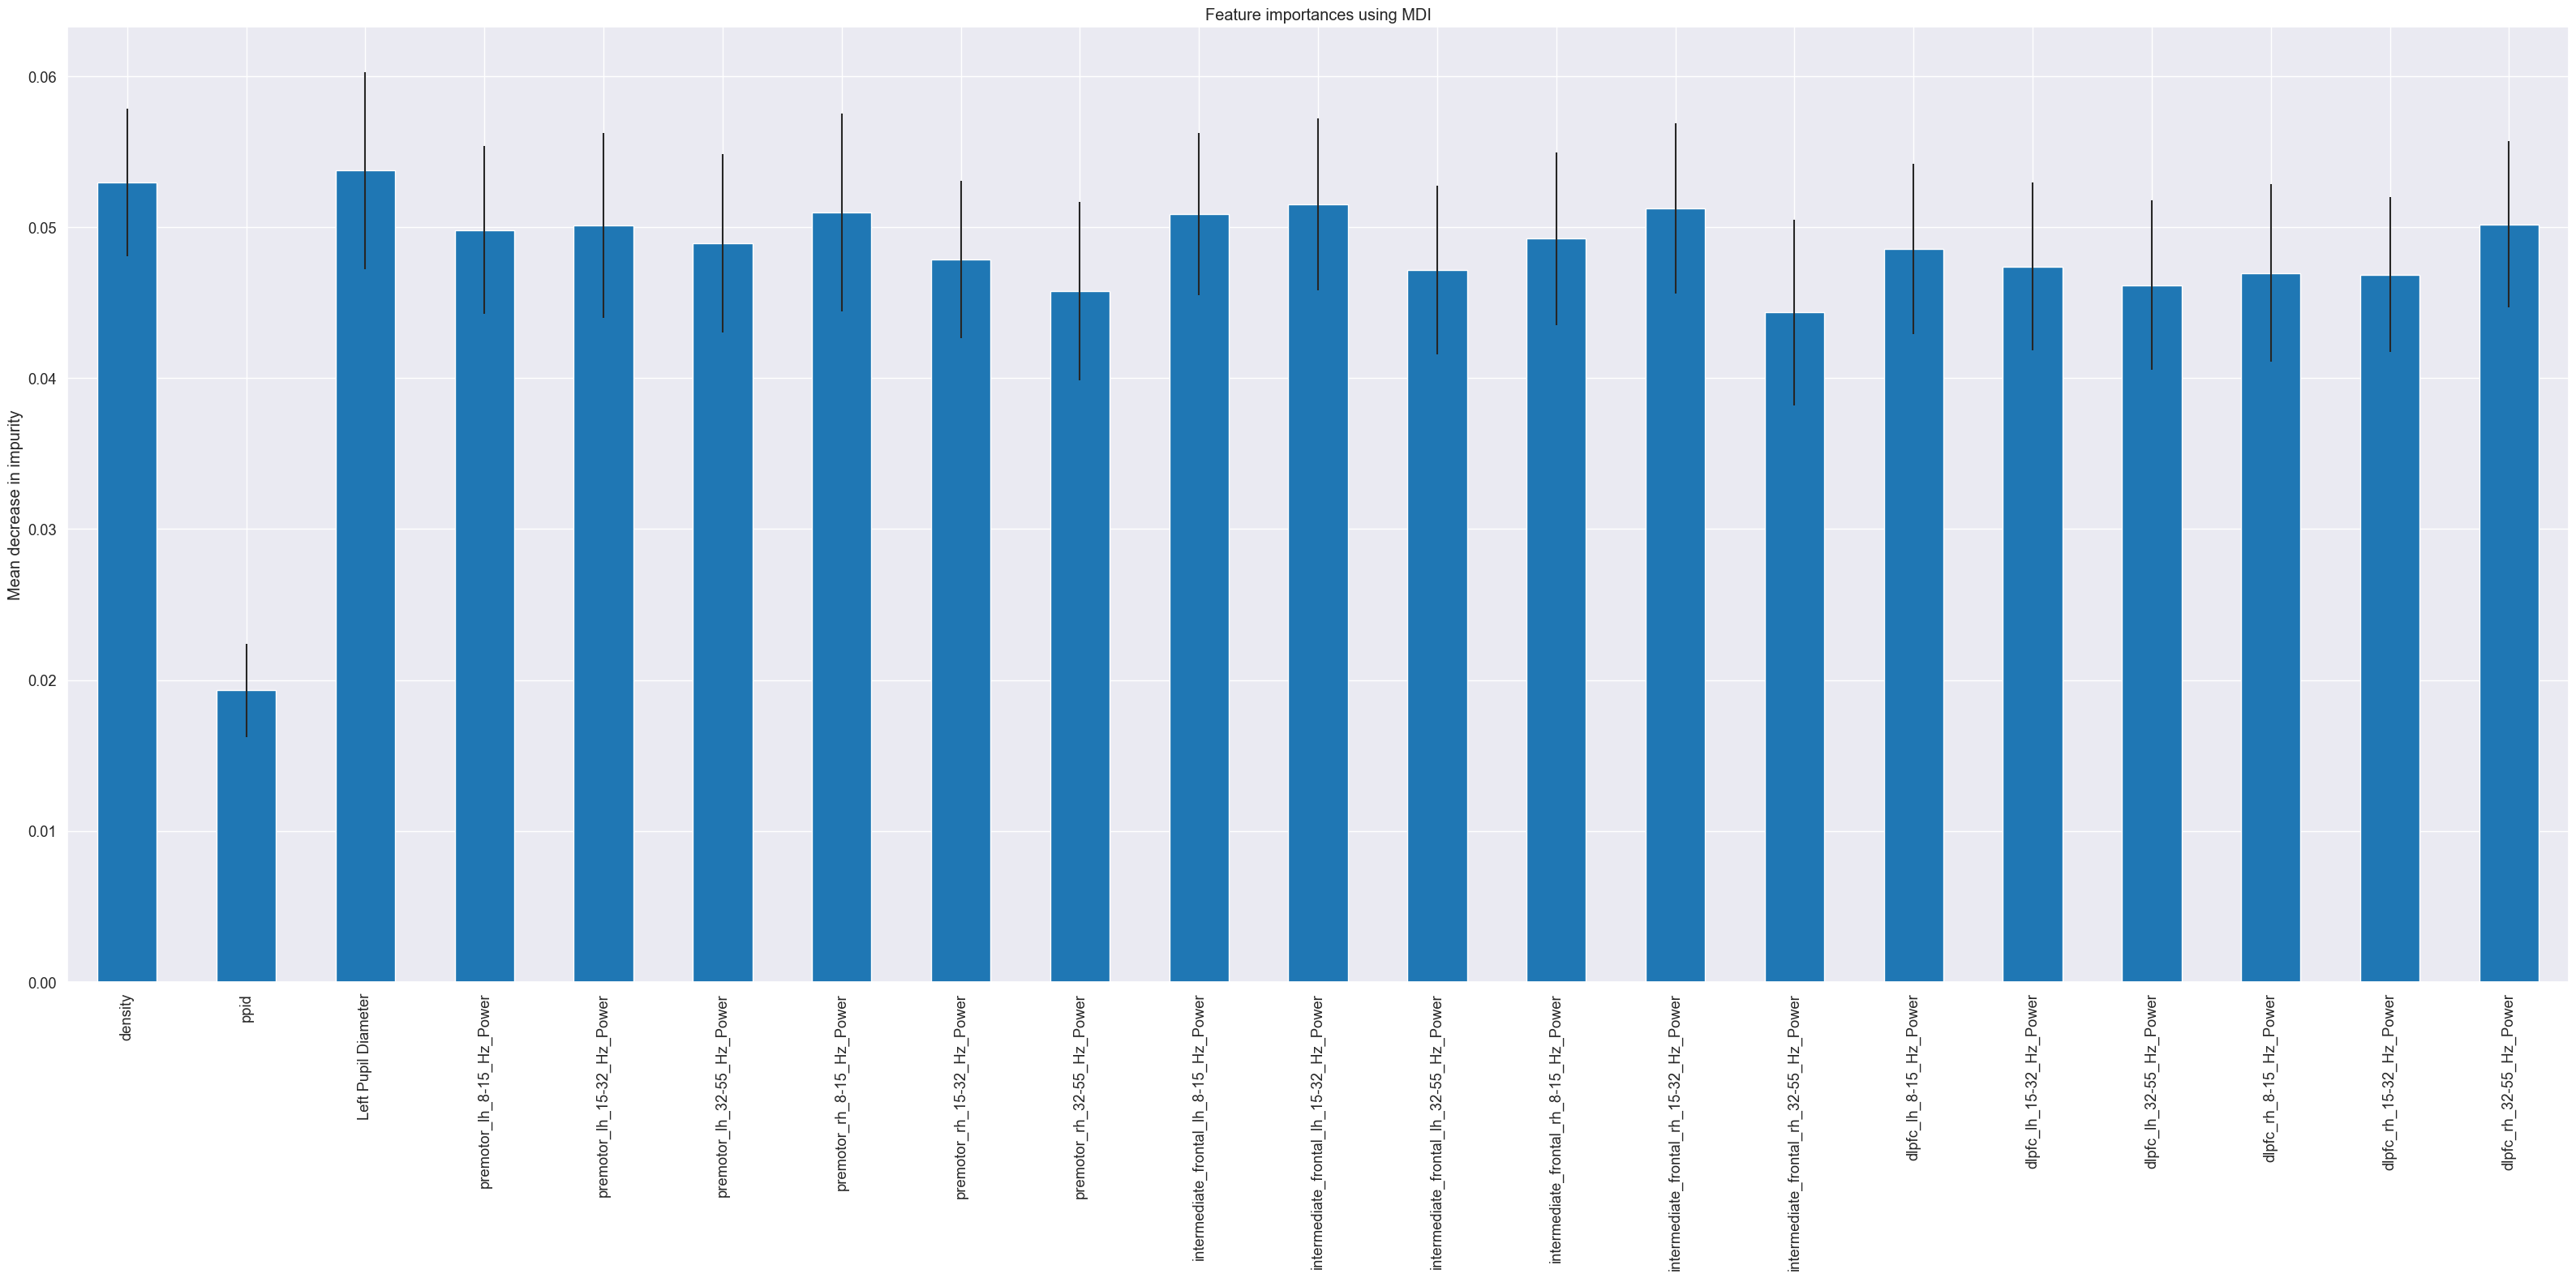

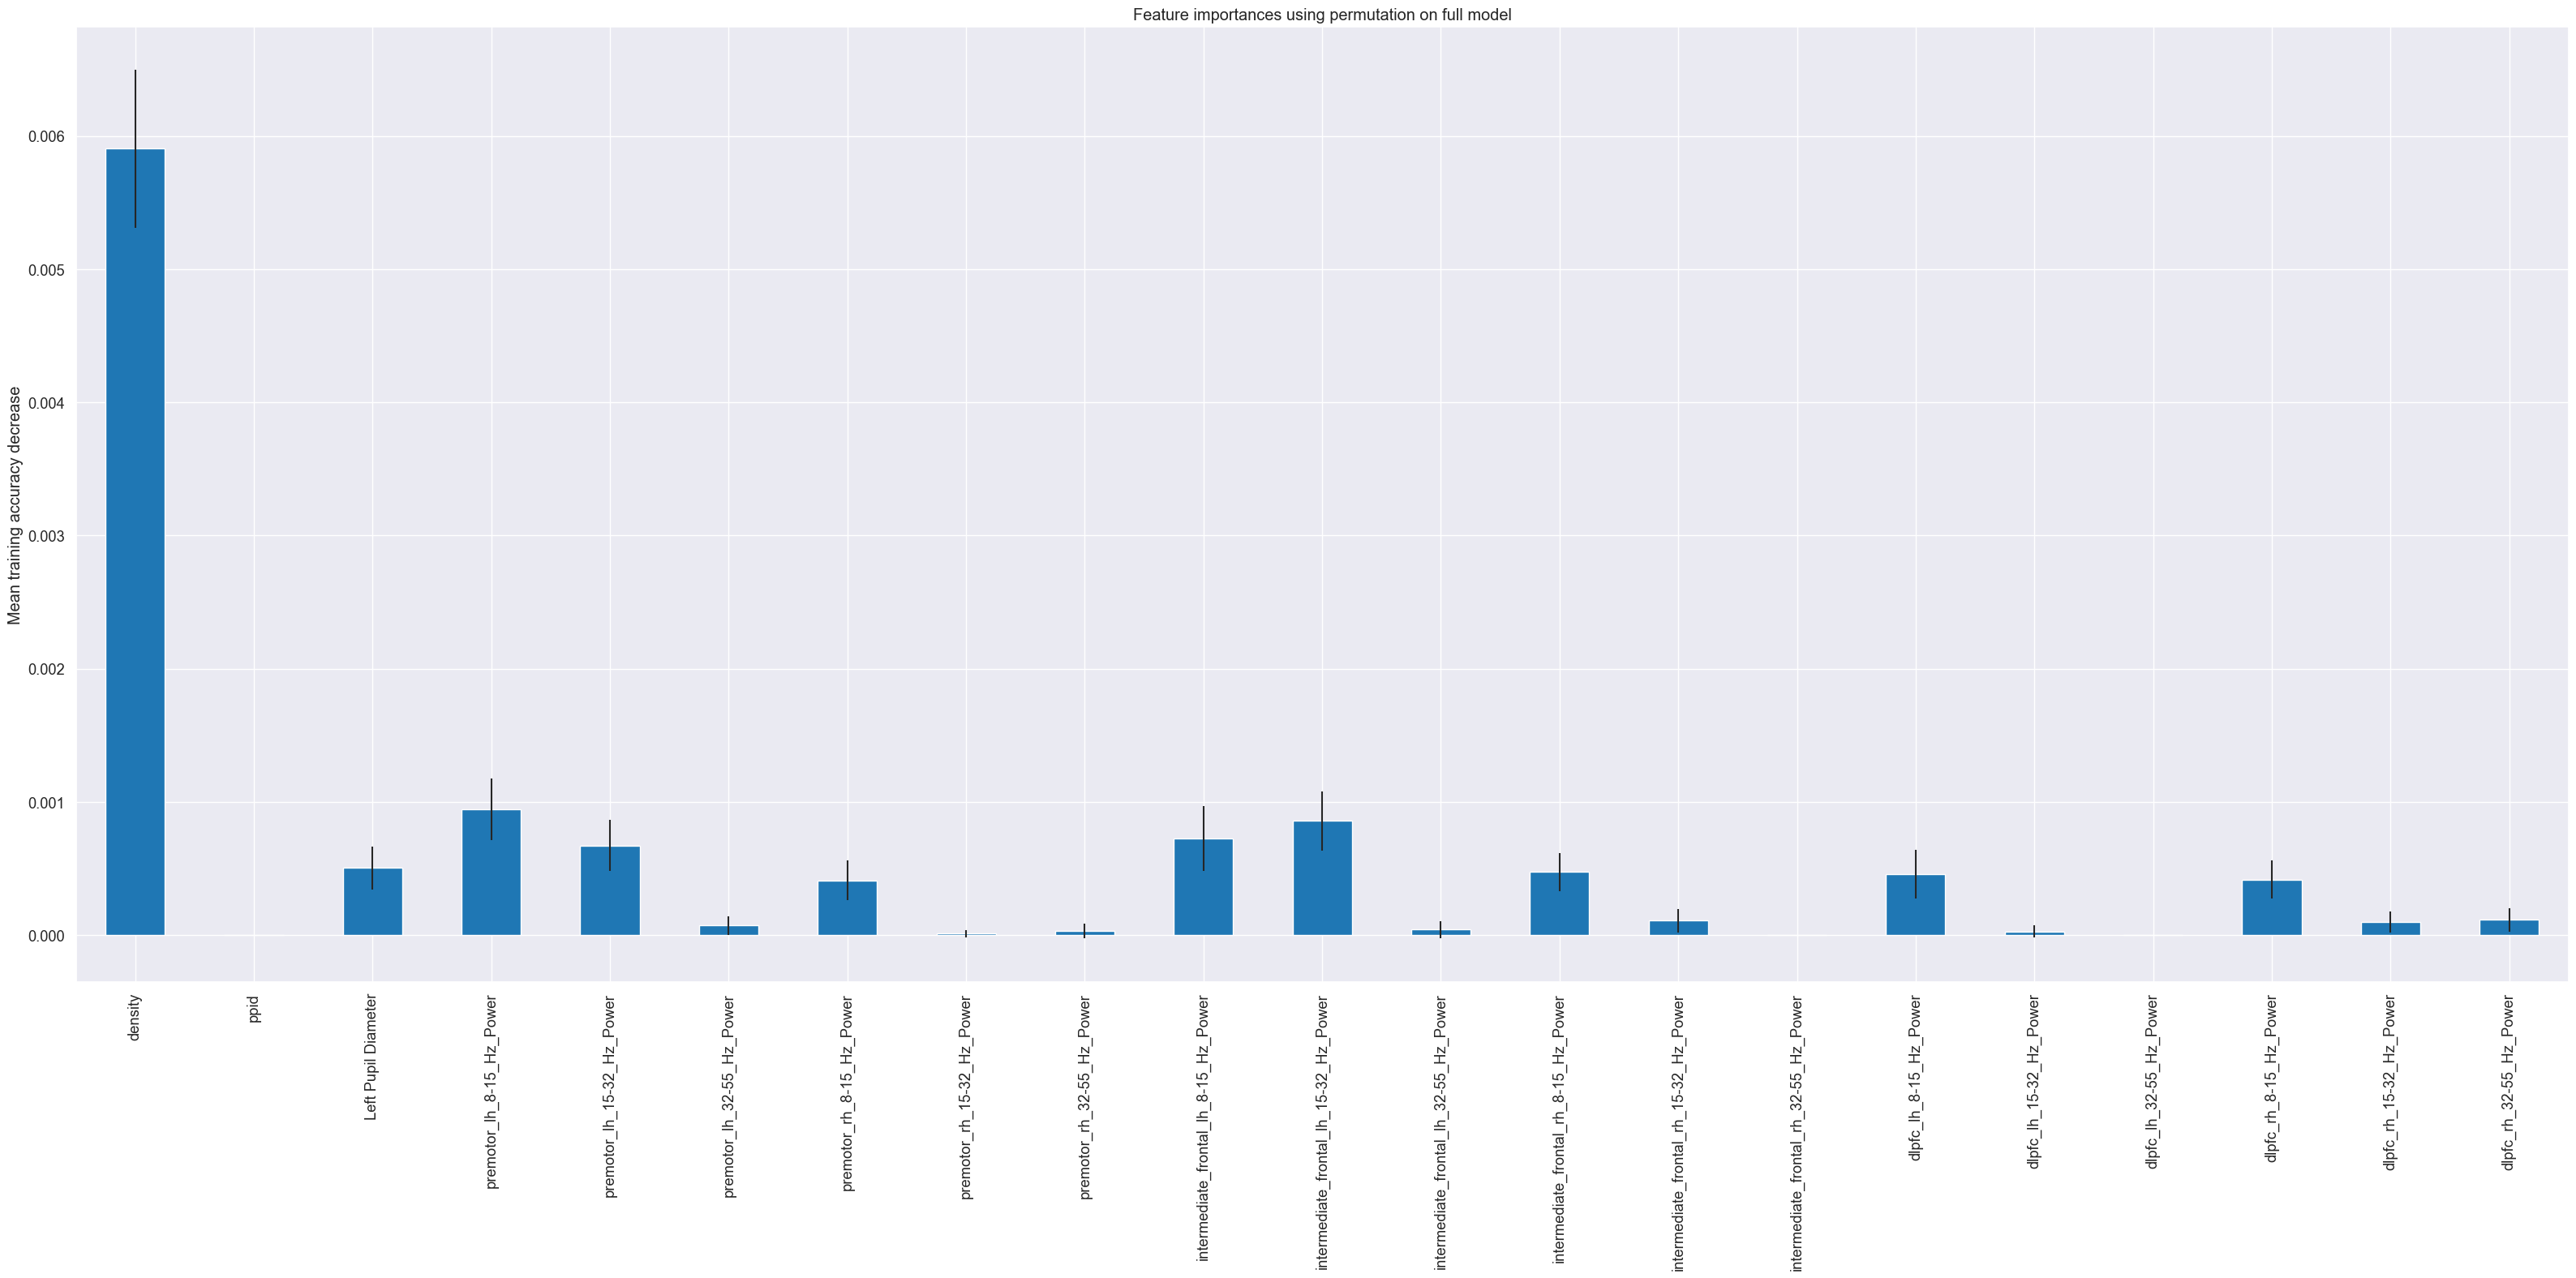

In [9]:
prediction = 'Steer_Wheel_Degree_Encoded'
predictors = ['density', 'ppid','Left Pupil Diameter','premotor_lh_8-15_Hz_Power', 'premotor_lh_15-32_Hz_Power',
            'premotor_lh_32-55_Hz_Power', 'premotor_rh_8-15_Hz_Power',
            'premotor_rh_15-32_Hz_Power', 'premotor_rh_32-55_Hz_Power',
            'intermediate_frontal_lh_8-15_Hz_Power', 'intermediate_frontal_lh_15-32_Hz_Power',
            'intermediate_frontal_lh_32-55_Hz_Power', 
            'intermediate_frontal_rh_8-15_Hz_Power', 'intermediate_frontal_rh_15-32_Hz_Power',
            'intermediate_frontal_rh_32-55_Hz_Power', 'dlpfc_lh_8-15_Hz_Power',
            'dlpfc_lh_15-32_Hz_Power', 'dlpfc_lh_32-55_Hz_Power', 'dlpfc_rh_8-15_Hz_Power',
            'dlpfc_rh_15-32_Hz_Power', 'dlpfc_rh_32-55_Hz_Power']

# filter rows
motor_dfs_filtered = motor_epochs_metadata.copy()
motor_dfs_filtered = motor_dfs_filtered[motor_dfs_filtered.spoken_difficulty != 'unknown']
rf_prediction_importances(motor_dfs_filtered, prediction, predictors, seed=42, calc_importances=True, plot=True)

size of dataset (2598, 4) lost 88 trials or 0.03276247207743857 as a result of removing nan values given the predictors
Test R2: -0.09121488937354716
Elapsed time to compute the importances: 0.007 seconds
Elapsed time to compute the importances: 4.603 seconds


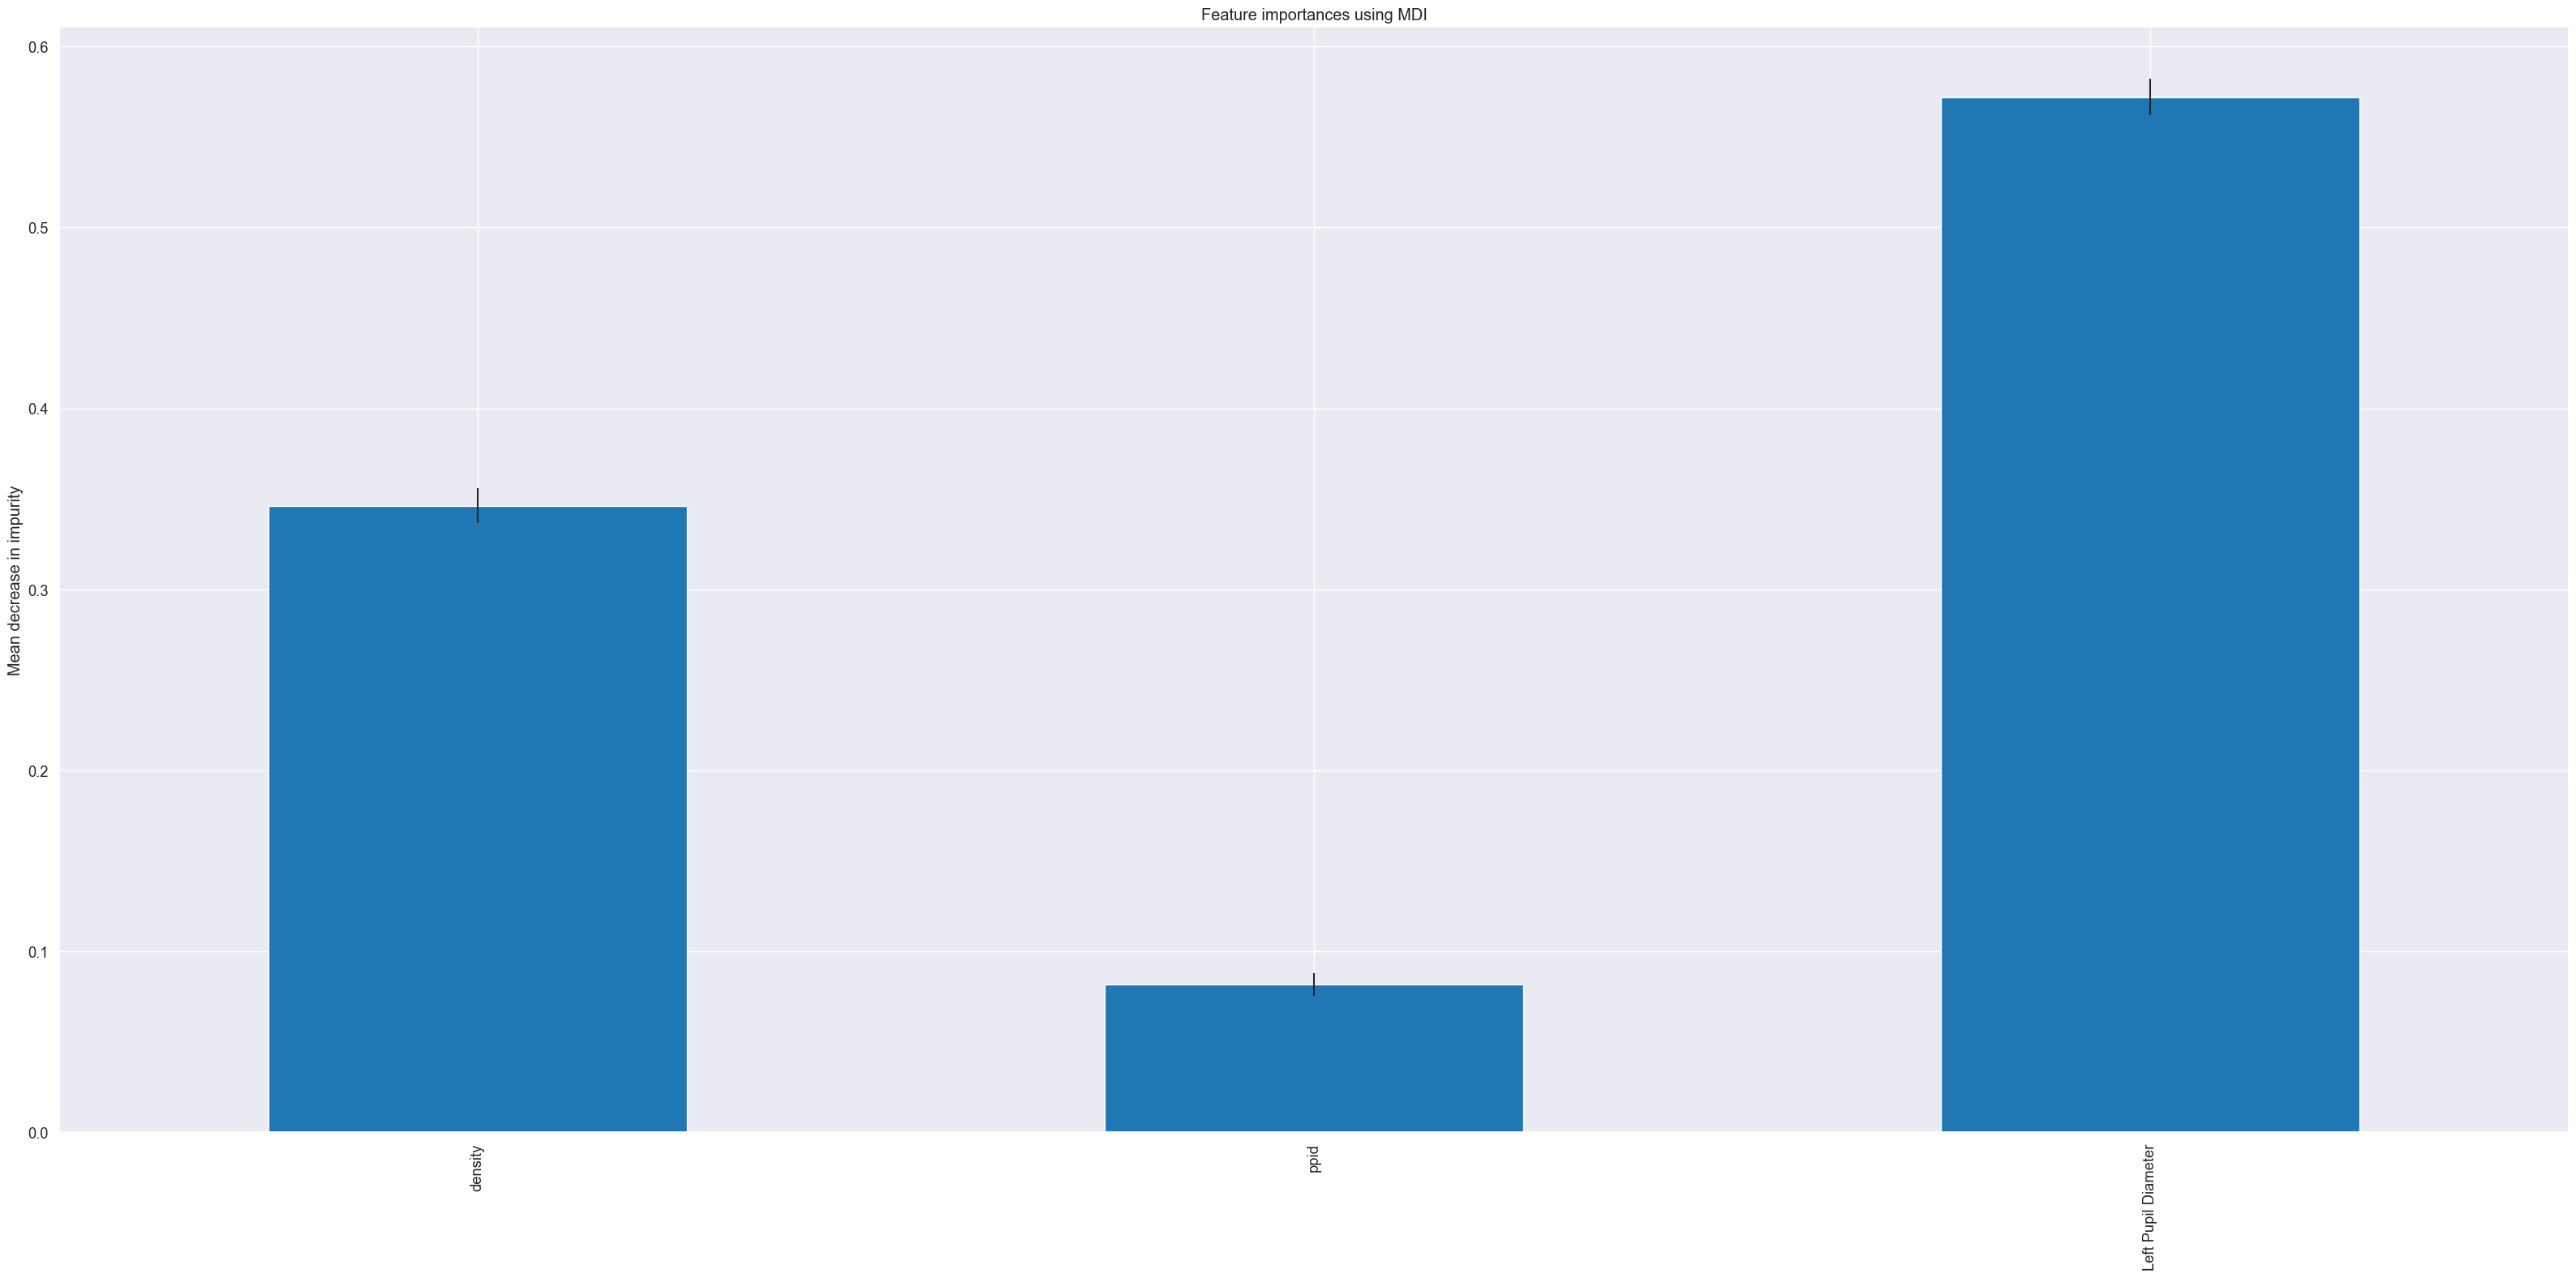

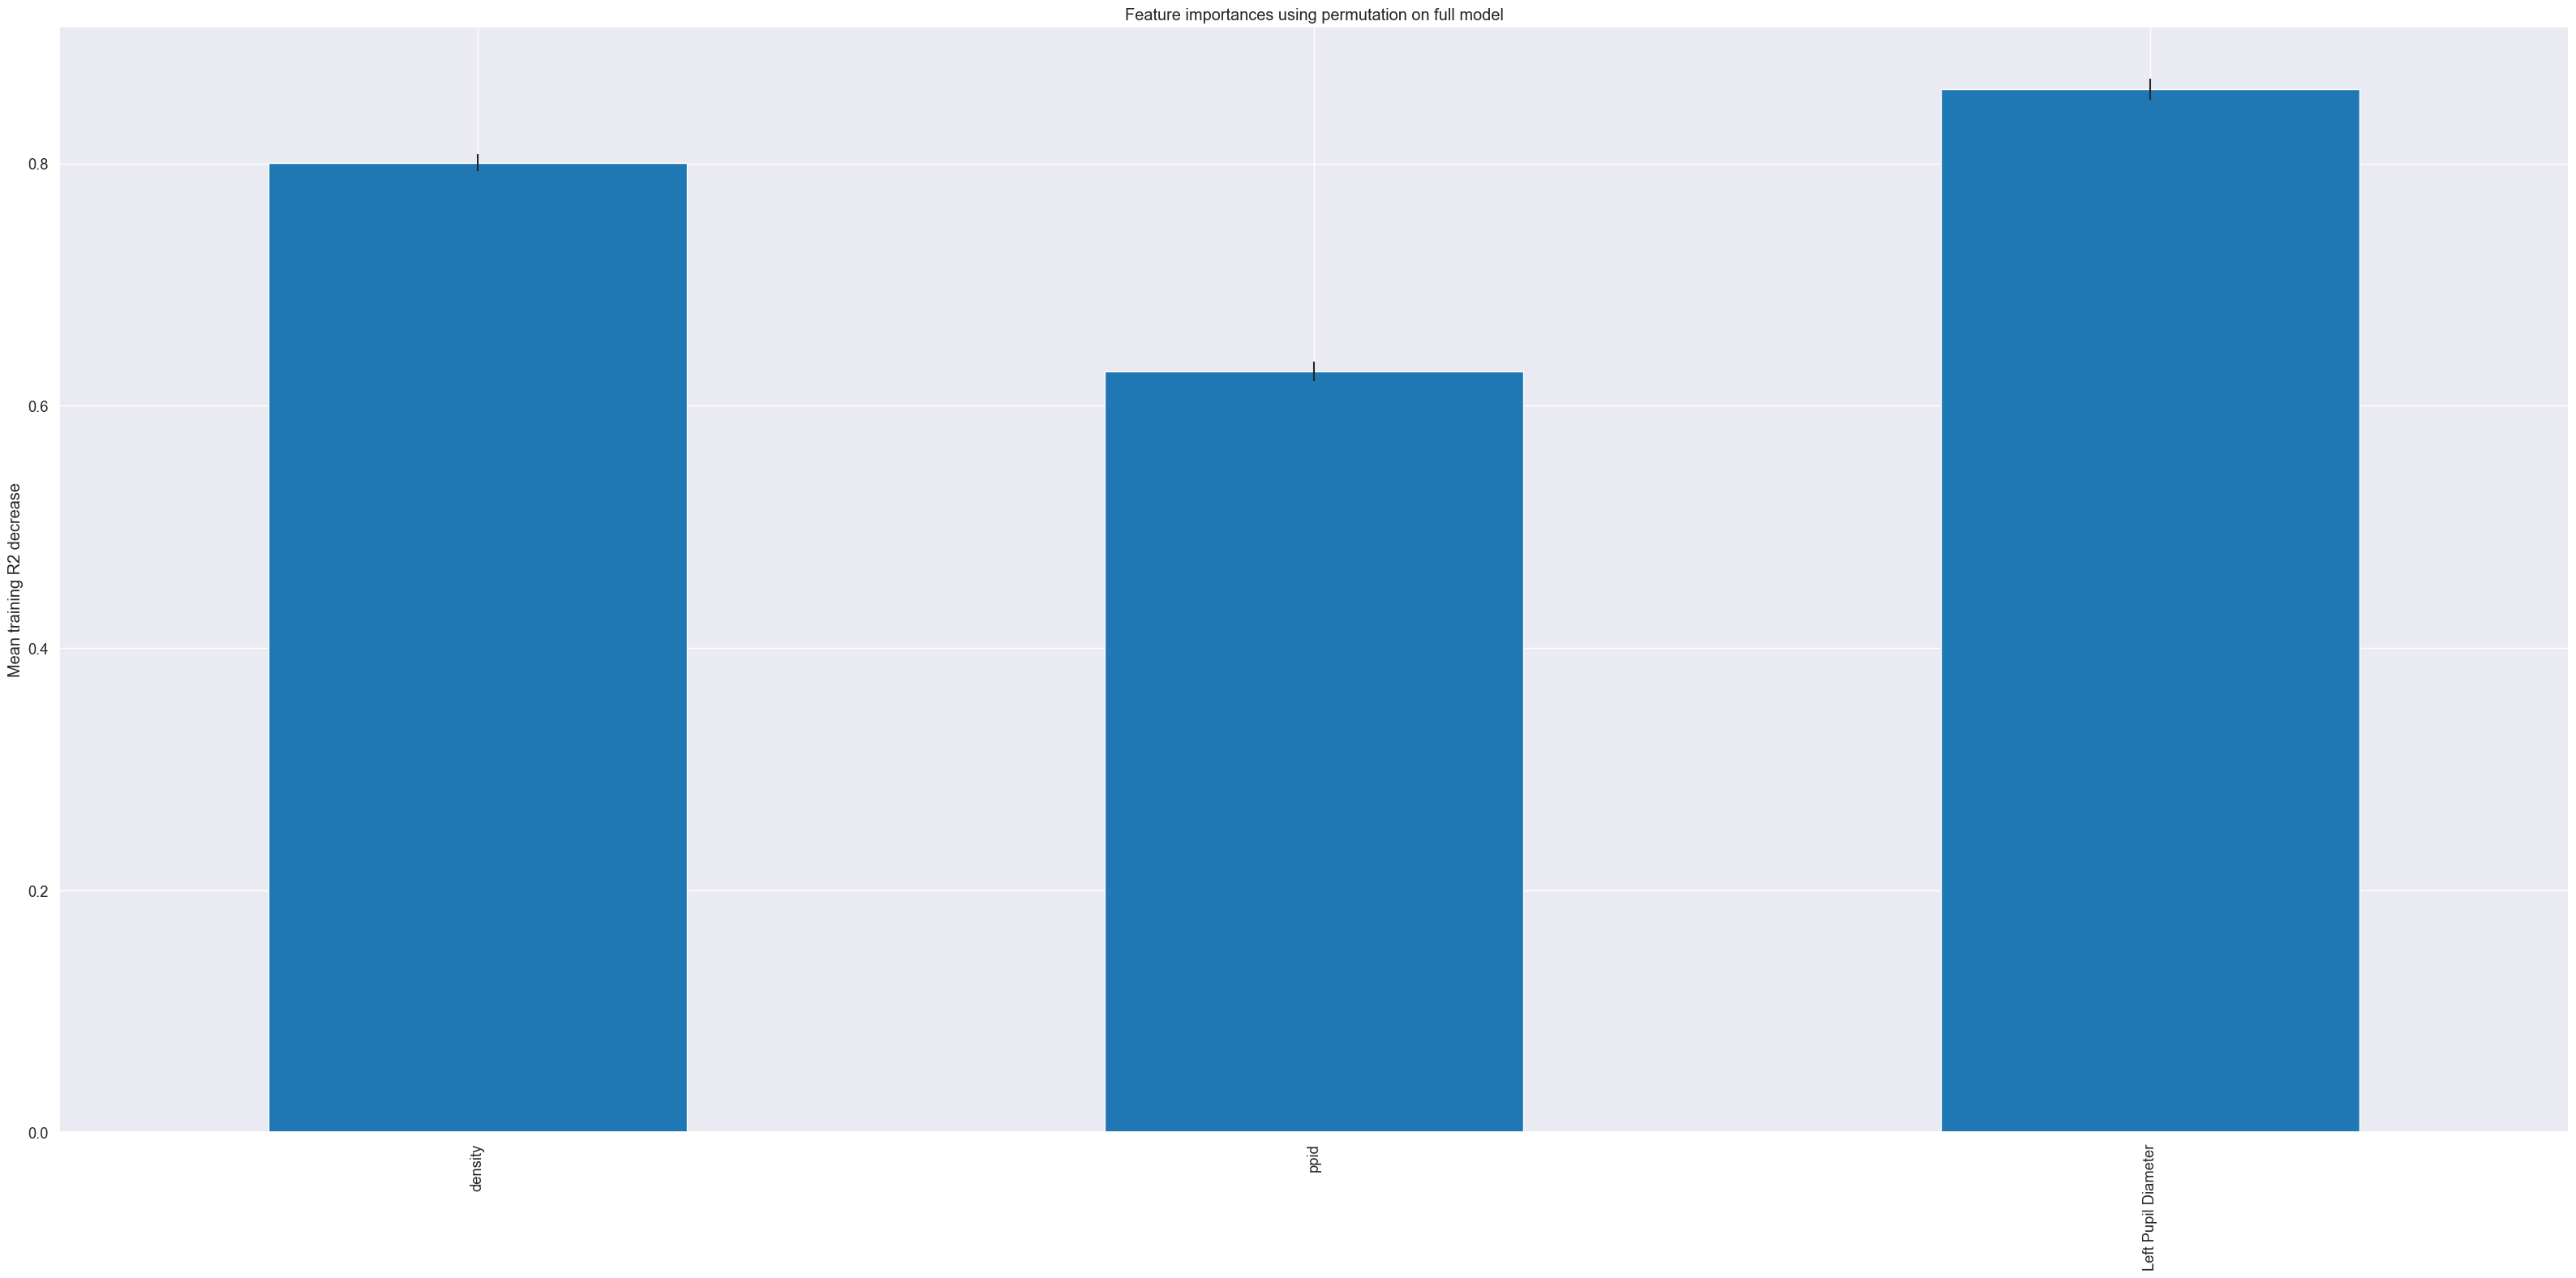

In [12]:
prediction = 'Abs_Steer_Wheel_Degree'
predictors = ['density', 'ppid','Left Pupil Diameter','premotor_lh_8-15_Hz_Power', 'premotor_lh_15-32_Hz_Power',
            'premotor_lh_32-55_Hz_Power', 'premotor_rh_8-15_Hz_Power',
            'premotor_rh_15-32_Hz_Power', 'premotor_rh_32-55_Hz_Power',
            'intermediate_frontal_lh_8-15_Hz_Power', 'intermediate_frontal_lh_15-32_Hz_Power',
            'intermediate_frontal_lh_32-55_Hz_Power',
            'intermediate_frontal_rh_8-15_Hz_Power', 'intermediate_frontal_rh_15-32_Hz_Power',
            'intermediate_frontal_rh_32-55_Hz_Power', 'dlpfc_lh_8-15_Hz_Power',
            'dlpfc_lh_15-32_Hz_Power', 'dlpfc_lh_32-55_Hz_Power', 'dlpfc_rh_8-15_Hz_Power',
            'dlpfc_rh_15-32_Hz_Power', 'dlpfc_rh_32-55_Hz_Power']

# filter rows
motor_dfs_filtered = motor_epochs_metadata.copy()
motor_dfs_filtered = motor_dfs_filtered[motor_dfs_filtered.spoken_difficulty != 'unknown']
rf_prediction_importances(motor_dfs_filtered, prediction, predictors, seed=42, pred_type='regression', calc_importances=True, plot=True)

## Simple t-test showing differences in DLPFC average activity between low and high conditions

In [ ]:
low_tcs = all_tcs[(motor_epochs.metadata.Steer_Wheel_Degree_Categorical == 'Low')]
high_tcs = all_tcs[(motor_epochs.metadata.Steer_Wheel_Degree_Categorical == 'High')]
        

for i in range(low_tcs.shape[1]):
    print(rel_mappings[rel_labels[i].name])
    trial_area_mean = low_tcs.mean(axis=2)
    trial_area_std = low_tcs.std(axis=2)
    sub_low_tcs = []
    for j in range(len(low_tcs)):
        sub_low_tcs.append((low_tcs[j,i]-trial_area_mean[j,i])/trial_area_std[j,i])

    h_trial_area_mean = high_tcs.mean(axis=2)
    h_trial_area_std = high_tcs.std(axis=2)
    sub_high_tcs = []
    for j in range(len(high_tcs)):
        sub_high_tcs.append((high_tcs[j,i]-h_trial_area_mean[j,i])/h_trial_area_std[j,i])
    
    print(scipy.stats.ttest_ind(np.array(sub_low_tcs).mean(axis=1), np.array(sub_high_tcs).mean(axis=1)))


# Cluster test

In [ ]:
evokeds_iterable = dict()

query = "Steer_Wheel_Degree_Categorical == '{}'"

for cond in motor_epochs.metadata['Steer_Wheel_Degree_Categorical'].unique():
    evokeds_iterable[str(cond)] = list(motor_epochs[query.format(cond)].iter_evoked())
mne.combine_evoked([low_motor_sensor.average(), high_motor_sensor.average()],
                            weights=[1, -1]).plot()
mne.combine_evoked([low_motor_avg, high_motor_avg],
                            weights=[1, -1]).plot()


In [ ]:
low_motor_data = [l.get_data() for l in low_motor]
low_motor_data = np.array(low_motor_data)
high_motor_data = [l.get_data() for l in high_motor]
high_motor_data = np.array(high_motor_data)
low_motor_avg = mne.combine_evoked(low_motor,weights='equal')
high_motor_avg = mne.combine_evoked(high_motor,weights='equal')

In [ ]:
significant_points = cluster_pv.reshape(t_obs.shape).T < .3
print(str(significant_points.sum()) + " points selected by TFCE ...")

In [ ]:
from mne.channels import find_ch_adjacency, make_1020_channel_selections
from mne.stats import spatio_temporal_cluster_test
# Calculate adjacency matrix between sensors from their locations
adjacency, _ = find_ch_adjacency(motor_epochs.info, "eeg")

# Extract data: transpose because the cluster test requires channels to be last
# In this case, inference is done over items. In the same manner, we could
# also conduct the test over, e.g., subjects.
X = [low_motor_data.transpose(0, 2, 1),
     high_motor_data.transpose(0, 2, 1)]
tfce = dict(start=.4, step=.4)  # ideally start and step would be smaller

# Calculate statistical thresholds
t_obs, clusters, cluster_pv, h0 = spatio_temporal_cluster_test(
    X, threshold=tfce, adjacency=adjacency,
    n_permutations=100, n_jobs = 5)  # a more standard number would be 1000+
significant_points = cluster_pv.reshape(t_obs.shape).T < .05
print(str(significant_points.sum()) + " points selected by TFCE ...")

# We need an evoked object to plot the image to be masked
evoked = mne.combine_evoked([low_motor_avg, high_motor_avg],
                            weights=[1, -1])  # calculate difference wave
time_unit = dict(time_unit="s")
evoked.plot_joint(title="Long vs. short words", ts_args=time_unit,
                  topomap_args=time_unit)  # show difference wave

# Create ROIs by checking channel labels
selections = make_1020_channel_selections(evoked.info, midline="12z")

# Visualize the results
fig, axes = plt.subplots(nrows=3, figsize=(8, 8))
axes = {sel: ax for sel, ax in zip(selections, axes.ravel())}
evoked.plot_image(axes=axes, group_by=selections, colorbar=False, show=False,
                  mask=significant_points, show_names="all", titles=None,
                  **time_unit)
plt.colorbar(axes["Left"].images[-1], ax=list(axes.values()), shrink=.3,
             label="µV")

plt.show()

## Source permutation t-tests with clustering

In [ ]:
#low_motor.resample(50, npad='auto')
condition1 = mne.minimum_norm.apply_inverse(low_motor_sensor.average(), inverse_operator, lambda2, method)
#high_motor.resample(50, npad='auto')
condition2 = mne.minimum_norm.apply_inverse(high_motor_sensor.average(), inverse_operator, lambda2, method)

tmin = condition1.tmin
tstep = condition1.tstep * 1000  # convert to milliseconds

In [ ]:
from mne import spatial_src_adjacency
from mne.stats import spatio_temporal_cluster_test, summarize_clusters_stc
src = mne.read_source_spaces(src_fname)
n_subjects1, n_subjects2 = 60, 60
n_vertices_fsave, n_times = condition1.data.shape
print('Simulating data for %d and %d subjects.' % (n_subjects1, n_subjects2))

#    Let's make sure our results replicate, so set the seed.
np.random.seed(0)
X1 = np.random.randn(n_vertices_fsave, n_times, n_subjects1)*10
X2 = np.random.randn(n_vertices_fsave, n_times, n_subjects2)*10
X1[:, :, :] += condition1.data[:, :, np.newaxis]
X2[:, :, :] += 3*condition2.data[:, :, np.newaxis]
#    We want to compare the overall activity levels for each subject
X1 = np.abs(X1)  # only magnitude
X2 = np.abs(X2)  # only magnitude
print('Computing adjacency.')
adjacency = spatial_src_adjacency(src)

#    Note that X needs to be a list of multi-dimensional array of shape
#    samples (subjects_k) × time × space, so we permute dimensions
X1 = np.transpose(X1, [2, 1, 0])
X2 = np.transpose(X2, [2, 1, 0])
X = [X1, X2]
# Now let's actually do the clustering. This can take a long time...
# Here we set the threshold quite high to reduce computation,
# and use a very low number of permutations for the same reason.
n_permutations = 50 # 50 to test, 1024 ideally
p_threshold = .05
f_threshold = stats.distributions.f.ppf(1. - p_threshold / 2.,
                                        n_subjects1 - 1, n_subjects2 - 1)
print('Clustering.')
F_obs, clusters, cluster_p_values, H0 = clu =\
    spatio_temporal_cluster_test(
        X, adjacency=adjacency, n_jobs=5, n_permutations=n_permutations,
        threshold=f_threshold, buffer_size=None)
#    Now select the clusters that are sig. at p < 0.05 (note that this value
#    is multiple-comparisons corrected).
good_cluster_inds = np.where(cluster_p_values < 0.05 )[0]

In [ ]:
print('Visualizing clusters.')

#    Now let's build a convenient representation of each cluster, where each
#    cluster becomes a "time point" in the SourceEstimate
fsave_vertices = [np.arange(10242), np.arange(10242)]
stc_all_cluster_vis = summarize_clusters_stc(clu, tstep=tstep,p_thresh=.05, tmin=-1,
                                             vertices=fsave_vertices,
                                             subject='fsaverage')

#    Let's actually plot the first "time point" in the SourceEstimate, which
#    shows all the clusters, weighted by duration

# blue blobs are for condition A != condition B
brain = stc_all_cluster_vis.plot('fsaverage', hemi='both',
                                 views='lateral', subjects_dir=subjects_dir,
                                 time_label='temporal extent (ms)',
                                 clim=dict(kind='value', lims=[0, 1, 40]))

## Across all motor epochs

In [ ]:
stc, residual = mne.minimum_norm.apply_inverse(motor_epochs.average(), inverse_operator, lambda2,
                              method=method, pick_ori=None,
                              return_residual=True, verbose=True)

In [ ]:
motor_epochs_forward = mne.apply_forward(fwd, stc, motor_epochs.info)
motor_epochs_forward.plot_topomap(title='Forward model topos of motor epochs',vlim=(-.1,.1))
motor_epochs.average().plot_topomap(title='Sensor data topos of motor epochs',vlim=(-.1,.1))

In [ ]:
brain=stc.plot()
#brain.add_label(annot_labels[73], borders=True, color='b') # to show labels

## Decoding source space data

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from mne.decoding import (cross_val_multiscore, LinearModel, SlidingEstimator,
                          get_coef)
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, make_scorer

In [ ]:
# Retrieve source space data into an array
X = np.array([stc.lh_data for stc in stcs])  # only keep left hemisphere
y = motor_epochs.metadata.Steer_Wheel_Degree_Encoded # for sparse: motor_epochs[::7]

# prepare a series of classifier applied at each time sample
clf = make_pipeline(StandardScaler(),  # z-score normalization
                    SelectKBest(f_classif, k=500),  # select features for speed
                    LinearModel(LogisticRegression(C=1, solver='liblinear')))
time_decod = SlidingEstimator(clf, scoring='roc_auc')

# Run cross-validated decoding analyses:
scores = cross_val_multiscore(time_decod, X, y, cv=5, n_jobs=None)

# Plot average decoding scores of 5 splits
fig, ax = plt.subplots(1)
ax.plot(motor_epochs.times, scores.mean(0), label='score')
ax.axhline(.5, color='k', linestyle='--', label='chance')
ax.axvline(0, color='k')
plt.legend()

In [ ]:
%matplotlib inline
# Plot average decoding scores of 5 splits
fig, ax = plt.subplots(1)
ax.plot(motor_epochs.times, scores.mean(0), label='score')
ax.axhline(.5, color='k', linestyle='--', label='chance')
ax.axvline(0, color='k')
plt.legend()

### CSP

In [ ]:
from mne.decoding import UnsupervisedSpatialFilter
from sklearn.decomposition import PCA, FastICA
interval = 100
stcs = mne.minimum_norm.apply_inverse_epochs(motor_epochs[::interval], inverse_operator,
                            lambda2=1.0 / snr ** 2, verbose=False,
                            method="eLORETA", pick_ori="normal")

In [ ]:
# Retrieve source space data into an array
print('starting')
X = np.array([stc.lh_data for stc in stcs])  # only keep left hemisphere
y = motor_epochs[::interval].metadata.Steer_Wheel_Degree_Encoded
print('decoding')
csp = mne.decoding.CSP(n_components=3, norm_trace=False)
clf_csp = make_pipeline(
    PCA(),
    csp,
    LinearModel(LogisticRegression(solver='liblinear'))
)
scores = cross_val_multiscore(clf_csp, X, y, cv=5, n_jobs=None)
print('CSP: %0.1f%%' % (100 * scores.mean(),))

In [ ]:

# Retrieve source space data into an array
X = np.array([stc.lh_data for stc in stcs])
y = motor_epochs[::7].metadata.Abs_Steer_Wheel_Degree

# prepare a series of classifier applied at each time sample
clf = make_pipeline(StandardScaler(),  # z-score normalization
                    SelectKBest(f_classif, k=500),  # select features for speed
                    LinearModel(LinearRegression()))
time_decod = SlidingEstimator(clf, scoring='neg_mean_squared_error')
# Run cross-validated decoding analyses:
scores = cross_val_multiscore(time_decod, X, y, cv=5, n_jobs=None)

# Plot average decoding scores of 5 splits
fig, ax = plt.subplots(1)
ax.plot(motor_epochs.times, -scores.mean(0), label='score')
ax.axhline(mean_squared_error(y,[np.mean(y)]*len(y)), color='k', linestyle='--', label='chance')
ax.axvline(0, color='k')
plt.legend()

In [ ]:
y = motor_epochs.metadata.Abs_Steer_Wheel_Degree

print(mean_squared_error(y,[np.mean(y)]*len(y),squared=False)), print(np.sqrt(0.025))

# Descriptives

## Trial level

In [ ]:
sns.histplot(data=trial_dfs, x="trial_duration", kde=True,hue='ppid',palette = 'tab10')
plt.box(False)

## Pupil Distributions

In [ ]:
plt.style.use('default')


g=sns.lmplot(data = trial_dfs, x='density',y='Raw Left Pupil Diameter',scatter=False,hue='ppid',palette = 'tab10')
g.set(xlim=(0, 0.8),xlabel='Trial opacity')


g = sns.jointplot(data=trial_dfs, x='density',y='Left Pupil Diameter', hue='ppid',palette = 'tab10',legend=False,xlim=(0,0.8),ylim=(1.5,7))
g.ax_joint.set_xlabel('Trial opacity')

for _,gr in trial_dfs.groupby('ppid'):
    h = sns.regplot(x='density',y='Left Pupil Diameter', data=gr, scatter=False, ax=g.ax_joint, truncate=False)
h.set(xlim=(0, 0.8),xlabel='Trial opacity',ylabel='Adjusted Pupil Diameter')

In [ ]:
%matplotlib inline
sns.set(font_scale=1)
plt.style.use('seaborn-white')

#motor_dfs_stacked = trial_dfs.groupby(['spoken_difficulty', 'pupil_bin']).size().reset_index().pivot(columns='pupil_bin', index='spoken_difficulty', values=0)
#motor_dfs_stacked.plot(kind='bar', stacked=True)
motor_dfs_stacked = motor_dfs.groupby(['Steer_Wheel_Degree_Categorical', 'pupil_bin']).size().reset_index().pivot(columns='pupil_bin', index='Steer_Wheel_Degree_Categorical', values=0)
motor_dfs_stacked.plot(kind='bar', stacked=True,xlabel='Motor intensity')


## Motor Data

In [ ]:
sns.histplot(data=motor_dfs, x="Steer_Wheel_Degree", kde=True,hue='ppid',palette = 'tab10')
plt.box(False)

In [ ]:
motor_dfs['referenced_motor_start'] = motor_dfs.groupby(['ppid','session'])['trial_start_time'].transform(
                     lambda x: x-x.iloc[0])
g = sns.relplot(data=motor_dfs[motor_dfs.ppid.isin([12,13,14,16])],x='referenced_motor_start',y='Abs_Steer_Wheel_Degree',
            hue='session',kind='scatter',col='ppid',col_wrap=2)
g.set_ylabels("|Steer Degree| -> Motor intensity", clear_inner=False)
g.set_xlabels("Motor event time", clear_inner=False)

### Turns sample

In [ ]:
plt.style.use('default')

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(4, 5)
# note that wheel is at 40Hz effectively
plt.subplot(211)

for i, row in motor_dfs.loc[(motor_dfs.ppid==12)].iterrows():
    if row['turn_type']=='right':
        baseline_adjust = np.array(row['post_steer_event_raw'])-row['post_steer_event_raw'][0]
        plt.plot(np.linspace(start=0, stop=30/40*1000, num=30), baseline_adjust, color="g", linewidth=.5)
        plt.tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False) # labels along the bottom edge are off
plt.box(False)

plt.subplot(212)

        
for i, row in motor_dfs.loc[(motor_dfs.ppid==12)].iterrows():
    if row['turn_type']=='left':
        baseline_adjust = np.array(row['post_steer_event_raw'])-row['post_steer_event_raw'][0]
        plt.plot(np.linspace(start=0, stop=30/40*1000, num=30),baseline_adjust, color="r", linewidth=.5)
    plt.xlabel("post-event time (msec)")
    plt.ylabel("steering wheel degrees")

plt.box(False)


# EEG Sensor analysis

## Significance test by region

In [ ]:
time_windows = []
all_times = list(np.linspace(-1,0,100))
for index, t in enumerate(all_times):
    if index > 0:
        time_windows.append((all_times[index-1], all_times[index]))

### Motor decisions

In [ ]:
#time_windows = ((-1.000,-.750), (-.75, 0))
elecs = all_regions
df_index = ['condition', 'epoch', 'time']

report = "{elec}, time: {tmin}-{tmax} s; t({df})={t_val:.3f}, p={p:.3f}"
print("\nTargeted statistical test results:")
#low_motor=low_pupil
#high_motor = high_pupil
fig, ax = plt.subplots()
ax.plot()
region_dict = {'premotor_regions': [0,'red'], 'intermediate_frontal': [.33,'blue'], 'dorsolateral_prefrontal': [.66,'green']}
for time_idx, (tmin, tmax) in enumerate(time_windows):
    long_df = high_motor.copy().crop(tmin, tmax).to_data_frame(index=df_index)
    short_df = low_motor.copy().crop(tmin, tmax).to_data_frame(index=df_index)
    for elec in elecs:
        # extract data
        A = long_df[elec]
        B = short_df[elec]

        # conduct t test
        t, p = stats.ttest_ind(A, B)

        # display results
        format_dict = dict(elec=elec, tmin=tmin, tmax=tmax,
                           df=len(motor_epochs.events) - 2, t_val=t, p=p)
        if p < 0.05:
            for index,e in enumerate(list(rel_regions.values())):
                if elec in e:
                    region = list(rel_regions.keys())[index]
                    ax.axvspan(tmin, tmax, ymin=region_dict[region][0], ymax=region_dict[region][0]+.33, alpha=1/len(rel_regions[region]), color=region_dict[region][1])
            # print(report.format(**format_dict))
ax.set_xlim([all_times[0], all_times[-1]])
ax.set_ylim([0, 30])
plt.show()

### Pupil diameter

In [ ]:
#time_windows = ((-1.000,-.750), (-.75, 0))
elecs = all_regions
df_index = ['condition', 'epoch', 'time']

report = "{elec}, time: {tmin}-{tmax} s; t({df})={t_val:.3f}, p={p:.3f}"
print("\nTargeted statistical test results:")
fig, ax = plt.subplots()
ax.plot()
region_dict = {'premotor_regions': [0,'red'], 'intermediate_frontal': [.33,'blue'], 'dorsolateral_prefrontal': [.66,'green']}
for time_idx, (tmin, tmax) in enumerate(time_windows):
    long_df = high_pupil.copy().crop(tmin, tmax).to_data_frame(index=df_index)
    short_df = low_pupil.copy().crop(tmin, tmax).to_data_frame(index=df_index)
    for elec in elecs:
        # extract data
        A = long_df[elec]
        B = short_df[elec]
        # conduct t test
        t, p = stats.ttest_ind(A, B)

        # display results
        format_dict = dict(elec=elec, tmin=tmin, tmax=tmax,
                           df=len(motor_epochs.events) - 2, t_val=t, p=p)
        if p < 0.05:
            for index,e in enumerate(list(rel_regions.values())):
                if elec in e:
                    region = list(rel_regions.keys())[index]
                    ax.axvspan(tmin, tmax, ymin=region_dict[region][0], ymax=region_dict[region][0]+.33, alpha=1/len(rel_regions[region]), color=region_dict[region][1])
            # print(report.format(**format_dict))
ax.set_xlim([all_times[0], all_times[-1]])
ax.set_ylim([0, 30])
plt.show()

In [ ]:
query = "pupil_bin == '{}'"
evokeds_iterable_pup={}
for cond in ['high', 'low']: # ignore nan
    evokeds_iterable_pup[str(cond)] = list(motor_epochs[query.format(cond)].iter_evoked())


# We need an evoked object to plot the image to be masked
evoked_comb = mne.combine_evoked([high_pupil.average(), low_pupil.average()],
                            weights=[1, -1])
time_unit = dict(time_unit="s")
evoked_comb.plot_joint(times=all_times[::15],title="High vs. low pupil diameter premovement", ts_args=time_unit,
                  topomap_args=time_unit,picks=all_regions)  # show difference wave


mne.viz.plot_compare_evokeds(evokeds_iterable_pup, cmap=('Pupil-linked arousal', 'PiYG'),
                             picks=rel_regions['dorsolateral_prefrontal'],combine='mean', show_sensors=True)
mne.viz.plot_compare_evokeds(evokeds_iterable_pup, cmap=('Pupil-linked arousal', 'PiYG'),
                             picks=rel_regions['intermediate_frontal'],combine='mean', show_sensors=True)
mne.viz.plot_compare_evokeds(evokeds_iterable_pup, cmap=('Pupil-linked arousal', 'PiYG'),
                             picks=rel_regions['premotor_regions'],combine='mean', show_sensors=True)

### Average difference between conditions (evoked) and by region

In [ ]:
%matplotlib inline


# We need an evoked object to plot the image to be masked
evoked_comb = mne.combine_evoked([high_motor.average(), low_motor.average()],
                            weights=[1, -1])
time_unit = dict(time_unit="s")
evoked_comb.plot_joint(times=all_times[::15],title="High vs. low intensity motor movements", ts_args=time_unit,
                  topomap_args=time_unit,picks=all_regions)  # show difference wave


mne.viz.plot_compare_evokeds(evokeds_iterable, cmap=('Motor event intensity', 'PiYG'),
                             picks=rel_regions['dorsolateral_prefrontal'],combine='mean', show_sensors=True)
mne.viz.plot_compare_evokeds(evokeds_iterable, cmap=('Motor event intensity', 'PiYG'),
                             picks=rel_regions['intermediate_frontal'],combine='mean', show_sensors=True)
mne.viz.plot_compare_evokeds(evokeds_iterable, cmap=('Motor event intensity', 'PiYG'),
                             picks=rel_regions['premotor_regions'],combine='mean', show_sensors=True)

In [ ]:
from mne.time_frequency import tfr_morlet, psd_multitaper, psd_welch


# freq_range = np.logspace(*np.log10([4, 55]), num=15)
freq_range = np.linspace(4, 56, 28)
n_cycles = freq_range / 2.

power_diff = tfr_morlet(mne.combine_evoked([high_motor.average(), low_motor.average()],
                            weights=[1, -1]), freqs=freq_range, n_cycles=n_cycles, use_fft=True, return_itc=False, n_jobs=-1)
power_diff_motor = tfr_morlet(mne.combine_evoked([high_motor.average(picks=rel_regions['premotor_regions']),
                                                            low_motor.average(picks=rel_regions['premotor_regions'])],
                            weights=[1, -1]), freqs=freq_range, n_cycles=n_cycles, use_fft=True, return_itc=False, n_jobs=-1)
power_diff_dlpfc = tfr_morlet(mne.combine_evoked([high_motor.average(picks=rel_regions['dorsolateral_prefrontal']),
                                                            low_motor.average(picks=rel_regions['dorsolateral_prefrontal'])],
                            weights=[1, -1]), freqs=freq_range, n_cycles=n_cycles, use_fft=True, return_itc=False, n_jobs=-1)
power_diff_if = tfr_morlet(mne.combine_evoked([high_motor.average(picks=rel_regions['intermediate_frontal']),
                                                            low_motor.average(picks=rel_regions['intermediate_frontal'])],
                            weights=[1, -1]), freqs=freq_range, n_cycles=n_cycles, use_fft=True, return_itc=False, n_jobs=-1)

In [ ]:
# to plot joint plots
#power_diff.plot(baseline=(-1,-.8),mode='logratio', tmin=-1, tmax=0, 
#                 timefreqs=[(-0.75, 15), (-.5, 30), (-.25, 10)])

# power_diff_dlpfc.plot(baseline=(-1,-.75),mode='logratio', tmin=-1, tmax=0)


# power_diff_if.plot(baseline=(-1,-.75),mode='logratio', tmin=-1, tmax=0)

figs = power_diff_motor.plot(baseline=(-1,-.75),mode='logratio', tmin=-1, tmax=0)


In [ ]:
power = power_diff

fig, axes = plt.subplots(1, 4, figsize=(14, 8))
topomap_kw = dict(ch_type='eeg', tmin=-1, tmax=0, baseline=(-1, -.75),
                  mode='logratio', show=False)
plot_dict = dict(Theta=dict(fmin=4, fmax=8), Alpha=dict(fmin=8, fmax=15), Beta=dict(fmin=15, fmax=32), Gamma=dict(fmin=32, fmax=55))
for ax, (title, fmin_fmax) in zip(axes, plot_dict.items()):
    power.plot_topomap(**fmin_fmax, axes=ax, **topomap_kw)
    ax.set_title(title)
fig.tight_layout()
fig.show()



# Statistical Tests

## U-tests

In [ ]:

def get_all_eeg_cols(input_df):
    rel_eeg_cols = []
    for each_region in all_regions:
        rel_eeg_cols.extend([col for col in input_df if col.startswith(each_region) and 'Power' in col])
    return rel_eeg_cols

def get_all_ts(input_df,rel_cols = None, condition=None, low_high=None):
    dct = defaultdict(dict)
    if not rel_cols:
        for x in input_df:
            for y in input_df:
                try:
                    dct[x] = {y: stats.mannwhitneyu(input_df[x], input_df[y]).pvalue}
                except TypeError:
                    pass
    else:
        for x in rel_cols:
            try:
                stat_result = stats.mannwhitneyu(input_df.loc[input_df[condition]==low_high[0],x].dropna(),
                                        input_df.loc[input_df[condition]==low_high[1],x].dropna())
                
                p_val = stat_result.pvalue
                dct[x] = [stat_result.statistic, p_val]
            except TypeError:
                pass
        return pd.DataFrame(dct,index=['stat','pvalue'])
    return pd.DataFrame(dct)


rel_eeg_cols = get_all_eeg_cols(motor_dfs)
rel_eeg_cols.extend(eye_cols)
rel_eeg_cols.extend(ecg_cols)
pupil_sigs = get_all_ts(motor_dfs,rel_cols = rel_eeg_cols,condition='pupil_bin', low_high=('low','high'))
#pupil_sigs.to_csv('pupil_sigs.csv',index=True)
motor_sigs = get_all_ts(motor_dfs,rel_cols = rel_eeg_cols,condition='Steer_Wheel_Degree_Categorical', low_high=('Low','High')) # or condition='Steer_Wheel_Degree_Categorical'
#motor_sigs.to_csv('motor_sigs.csv',index=True)


## Linear Mixed Effects Results

In [3]:
import statsmodels.formula.api as smf
# from statsmodels.genmod.bayes_mixed_glm import BinomialBayesMixedGLM

results_dict = defaultdict(list)
for resp_var in ['FC3_15-32_Hz_Power','FC1_15-32_Hz_Power', 'FCz_15-32_Hz_Power', 'FC2_15-32_Hz_Power', 'FC4_15-32_Hz_Power']:
    try:
        #motor_dfs_nonnan = motor_dfs[['Left Pupil Diameter','ppid',resp_var,'Steer_Wheel_Degree_Categorical','Abs_Steer_Wheel_Degree']].dropna()
        motor_dfs_nonnan = motor_dfs[['Left Pupil Diameter','ppid',resp_var,'Abs_Steer_Wheel_Degree']].dropna()
        md = smf.mixedlm(f"Q('{resp_var}') ~ Q('Left Pupil Diameter') + Abs_Steer_Wheel_Degree + Q('Left Pupil Diameter'):Abs_Steer_Wheel_Degree",
                         motor_dfs_nonnan, groups=motor_dfs_nonnan["ppid"])
        #random = {"a": '0 + C(ppid)'}
        #md = BinomialBayesMixedGLM.from_formula("Q('FC3_4-8_Hz_Power') ~ Q('Left Pupil Diameter') + C(Steer_Wheel_Degree_Categorical) + Q('Left Pupil Diameter'):C(Steer_Wheel_Degree_Categorical)",
        #                 random, motor_dfs_nonnan)

        mdf = md.fit()
        for each_var in [i for i,v in enumerate(mdf.pvalues.values) if v < 0.05]:
            if each_var > 0 and each_var < len(mdf.pvalues)-1: # don't count first or last
                results_dict[resp_var].append(list(mdf.pvalues.index)[each_var])
        print(mdf.summary())
    except:
        pass
# pd.DataFrame(list(results_dict.values()), index=results_dict.keys()).to_csv('glm_results.csv')
pd.DataFrame(list(results_dict.values()), index=results_dict.keys())

/Users/schko/.conda/envs/mna/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/schko/.conda/envs/mna/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/schko/.conda/envs/mna/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                          Mixed Linear Model Regression Results
Model:                   MixedLM        Dependent Variable:        Q('FC3_15-32_Hz_Power')
No. Observations:        7817           Method:                    REML                   
No. Groups:              10             Scale:                     0.0036                 
Min. group size:         499            Log-Likelihood:            10906.6326             
Max. group size:         968            Converged:                 Yes                    
Mean group size:         781.7                                                            
------------------------------------------------------------------------------------------
                                                Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------------------
Intercept                                        0.149    0.012 12.843 0.000  0.126  0.172
Q('Left Pupil Diameter')  

/Users/schko/.conda/envs/mna/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                          Mixed Linear Model Regression Results
Model:                   MixedLM        Dependent Variable:        Q('FC2_15-32_Hz_Power')
No. Observations:        7817           Method:                    REML                   
No. Groups:              10             Scale:                     0.0028                 
Min. group size:         499            Log-Likelihood:            11780.1785             
Max. group size:         968            Converged:                 Yes                    
Mean group size:         781.7                                                            
------------------------------------------------------------------------------------------
                                                Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------------------
Intercept                                        0.133    0.011 12.204 0.000  0.111  0.154
Q('Left Pupil Diameter')  

/Users/schko/.conda/envs/mna/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


,0,1
FC3_15-32_Hz_Power,Q('Left Pupil Diameter'),Abs_Steer_Wheel_Degree
FC1_15-32_Hz_Power,Q('Left Pupil Diameter'),None
FCz_15-32_Hz_Power,Q('Left Pupil Diameter'),None
FC4_15-32_Hz_Power,Q('Left Pupil Diameter'),None


##  Predict motor category using non-PMC, exploration-related data

In [ ]:
all_vars = ['FC3_4-8_Hz_Power', 'FC3_8-15_Hz_Power', 'FC3_15-32_Hz_Power', 'FC3_32-55_Hz_Power', 'FC1_4-8_Hz_Power', 'FC1_8-15_Hz_Power',
            'FC1_15-32_Hz_Power', 'FC1_32-55_Hz_Power', 'FCz_4-8_Hz_Power', 'FCz_8-15_Hz_Power', 'FCz_15-32_Hz_Power', 'FCz_32-55_Hz_Power',
            'FC2_4-8_Hz_Power', 'FC2_8-15_Hz_Power', 'FC2_15-32_Hz_Power', 'FC2_32-55_Hz_Power', 'FC4_4-8_Hz_Power', 'FC4_8-15_Hz_Power',
            'FC4_15-32_Hz_Power', 'FC4_32-55_Hz_Power','AF3_4-8_Hz_Power', 'AF3_8-15_Hz_Power', 'AF3_15-32_Hz_Power', 'AF3_32-55_Hz_Power', 'AFz_4-8_Hz_Power', 'AFz_8-15_Hz_Power',
       'AFz_15-32_Hz_Power', 'AFz_32-55_Hz_Power', 'AF4_4-8_Hz_Power', 'AF4_8-15_Hz_Power', 'AF4_15-32_Hz_Power', 'AF4_32-55_Hz_Power',
        'Left Pupil Diameter', 'NSLR_count_Fixation', 'NSLR_count_Saccade',
       'NSLR_mean_duration_Fixation', 'NSLR_mean_duration_Saccade', 'NSLR_first_onset_Fixation',
       'NSLR_first_onset_Saccade', 'density', 'bpm', 'sdnn', 'rmssd', 'pnn50', 'ppid', 'Abs_Steer_Wheel_Degree',
            'Steer_Wheel_Degree_Encoded','Steer_Wheel_Degree','removed_beat_rate']
predictions = ['FC3_15-32_Hz_Power', 'FC1_15-32_Hz_Power', 'FCz_15-32_Hz_Power', 
            'FC2_15-32_Hz_Power', 
            'FC4_15-32_Hz_Power']
# chosen from  Boudewyn and 
predictors = ['AF3_32-55_Hz_Power', 'AFz_32-55_Hz_Power', 'AF4_32-55_Hz_Power',
              'Left Pupil Diameter','NSLR_count_Saccade','NSLR_mean_duration_Saccade', 
       'NSLR_first_onset_Saccade', 'density', 'bpm','rmssd']
motor_dfs_nonnan = motor_dfs[all_vars].dropna()
counts = defaultdict(int)
weights = defaultdict(float)
significance = defaultdict(str)
connections = {}
for p in predictions:
    md = sm.regression.mixed_linear_model.MixedLM(motor_dfs_nonnan[p],motor_dfs_nonnan[predictors],
                     groups=motor_dfs_nonnan["ppid"])
    mdf = md.fit()
    # display(mdf.summary())
    for each_sign in list(np.array(predictors)[np.where(mdf.pvalues[:-1]<0.05)]):
        round_weight = "{:.2f}".format(mdf.params[each_sign])
        found_in_dict = False
        if mdf.pvalues[each_sign] < 0.001:
            sign = '***'
        elif mdf.pvalues[each_sign] < 0.01:
            sign = '**'
        else:
            sign = '*'
        if '4-8_Hz_Power' in each_sign:
            region = 'Theta'
            counts[(p, 'DL-PFC ' + region)] += 1
            weights[(p, 'DL-PFC ' + region)] += mdf.params[each_sign]
            significance[(p, 'DL-PFC ' + region)] += f"{each_sign.split('_',1)[0]} ({round_weight}{sign}) "
        elif '8-15_Hz_Power' in each_sign:
            region = 'Alpha'
            counts[(p, 'DL-PFC ' + region)] += 1
            weights[(p, 'DL-PFC ' + region)] += mdf.params[each_sign]
            significance[(p, 'DL-PFC ' + region)] += f"{each_sign.split('_',1)[0]} ({round_weight}{sign}) "
        elif '15-32_Hz_Power' in each_sign:
            region = 'Beta'
            counts[(p, 'DL-PFC ' + region)] += 1
            weights[(p, 'DL-PFC ' + region)] += mdf.params[each_sign]
            significance[(p, 'DL-PFC ' + region)] += f"{each_sign.split('_',1)[0]} ({round_weight}{sign}) "
        elif '32-55_Hz_Power' in each_sign:
            region = 'Gamma'
            counts[(p, 'DL-PFC ' + region)] += 1
            weights[(p, 'DL-PFC ' + region)] += mdf.params[each_sign]
            significance[(p, 'DL-PFC ' + region)] += f"{each_sign.split('_',1)[0]} ({round_weight}{sign}) "
        else:
            counts[(p, each_sign)] += 1
            weights[(p, each_sign)] += mdf.params[each_sign]
            significance[(p, each_sign)] += f"{each_sign} ({round_weight}{sign}) "
    #print(f"The features that significantly predict {p} are {list(np.array(predictors)[np.where(mdf.pvalues[:-1]<0.05)])}")
counts_df = pd.DataFrame(counts,index=[0]).T.sort_values(0,ascending=False)
display(pd.DataFrame(counts,index=[0]).T)
# note that where p<0.05 we can realiably expect they have some predictive power for motor data

In [ ]:
weights_df = pd.DataFrame(weights,index=[0]).T.reset_index()
sign_df = pd.DataFrame(significance,index=[0]).T.reset_index()
weights_df = weights_df.merge(sign_df,on=['level_0', 'level_1'])
weights_df = weights_df.rename(columns={'level_0': 'Prediction', 'level_1': 'Predictor Class', '0_x': 'Average Coefficient', '0_y': 'Predictor (sign.)'})
rename_dict = {'index':'measure','Abs_Steer_Wheel_Degree':'Motor intensity (deg)', 'density': 'Trial opacity',
               'NSLR_count_Saccade': 'Saccade count',
               'NSLR_mean_duration_Saccade': 'Saccade duration (ms)',
               'NSLR_first_onset_Saccade': 'First saccade (ms)',
              '_8-15_Hz_Power': ' Alpha',
               '_15-32_Hz_Power': '',
              'bpm':'BPM', 'rmssd':'RMSSD (ms)','pnn50':'PNN50','Left Pupil Diameter':'Pupil Diameter (mm)'
              }
weights_df = weights_df.replace(rename_dict, regex=True)

weights_df = weights_df[['Prediction', 'Predictor Class', 'Predictor (sign.)']]
display(weights_df)
print(weights_df.set_index(['Prediction', 'Predictor Class']).to_latex(float_format="{:0.2f}".format))

##  Predict motor intensity using PMC, exploitation-related data

In [4]:

all_vars = ['FC3_4-8_Hz_Power', 'FC3_8-15_Hz_Power', 'FC3_15-32_Hz_Power', 'FC3_32-55_Hz_Power', 'FC1_4-8_Hz_Power', 'FC1_8-15_Hz_Power',
            'FC1_15-32_Hz_Power', 'FC1_32-55_Hz_Power', 'FCz_4-8_Hz_Power', 'FCz_8-15_Hz_Power', 'FCz_15-32_Hz_Power', 'FCz_32-55_Hz_Power',
            'FC2_4-8_Hz_Power', 'FC2_8-15_Hz_Power', 'FC2_15-32_Hz_Power', 'FC2_32-55_Hz_Power', 'FC4_4-8_Hz_Power', 'FC4_8-15_Hz_Power',
            'FC4_15-32_Hz_Power', 'FC4_32-55_Hz_Power','Abs_Steer_Wheel_Degree','ppid',
            'Left Pupil Diameter','NSLR_mean_duration_Saccade','NSLR_count_Saccade','bpm','rmssd','pnn50',
            'Steer_Wheel_Degree_Encoded','Steer_Wheel_Degree']
predictors = ['FC3_4-8_Hz_Power', 'FC3_8-15_Hz_Power', 'FC3_15-32_Hz_Power', 'FC3_32-55_Hz_Power', 'FC1_4-8_Hz_Power', 'FC1_8-15_Hz_Power',
            'FC1_15-32_Hz_Power', 'FC1_32-55_Hz_Power', 'FCz_4-8_Hz_Power', 'FCz_8-15_Hz_Power', 'FCz_15-32_Hz_Power', 'FCz_32-55_Hz_Power',
            'FC2_4-8_Hz_Power', 'FC2_8-15_Hz_Power', 'FC2_15-32_Hz_Power', 'FC2_32-55_Hz_Power', 'FC4_4-8_Hz_Power', 'FC4_8-15_Hz_Power',
            'FC4_15-32_Hz_Power', 'FC4_32-55_Hz_Power',
             'Left Pupil Diameter','NSLR_mean_duration_Saccade','NSLR_count_Saccade','bpm','rmssd','pnn50',]
motor_dfs_nonnan = motor_dfs[all_vars].dropna()
md = sm.regression.mixed_linear_model.MixedLM(motor_dfs_nonnan['Abs_Steer_Wheel_Degree'],motor_dfs_nonnan[predictors],
                 groups=motor_dfs_nonnan["ppid"])
mdf = md.fit()
display(mdf.summary())
print(f"The features that significantly predict motor intensity are {list(np.array(predictors)[np.where(mdf.pvalues[:-1]<0.05)])}")

# note that where p<0.05 we can realiably expect they have some predictive power for motor data

KeyError: "['NSLR_mean_duration_Saccade', 'NSLR_count_Saccade', 'bpm', 'rmssd', 'pnn50'] not in index"

In [ ]:
import scipy.stats as st
data = result.importances.T
cis = st.t.interval(alpha=0.95, df=len(data)-1, loc=np.mean(data), scale=st.sem(data))

#result.importances.shape, result.importances_mean.shape

In [ ]:
motor_dfs[['spoken_difficulty','spoken_difficulty_encoded']]

## Correlation analysis

In [ ]:
motor_dfs_corr = motor_dfs[['Left Pupil Diameter','NSLR_mean_duration_Saccade','NSLR_count_Saccade','Abs_Steer_Wheel_Degree','density',
                            'bpm','rmssd','pnn50',
                            'FC3_8-15_Hz_Power','FC1_8-15_Hz_Power', 'FCz_8-15_Hz_Power','FC2_8-15_Hz_Power','FC4_8-15_Hz_Power',
                            'FC3_15-32_Hz_Power', 'FC1_15-32_Hz_Power', 'FCz_15-32_Hz_Power', 'FC2_15-32_Hz_Power', 'FC4_15-32_Hz_Power']].dropna()
motor_dfs_corr['NSLR_mean_duration_Saccade'] *= 1000
motor_dfs_corr['Abs_Steer_Wheel_Degree'] *= 100
rho = motor_dfs_corr.corr(method='spearman')
pval = motor_dfs_corr.corr(method=lambda x, y: spearmanr(x, y)[1]) - np.eye(*rho.shape)
p = pval.applymap(lambda x: ''.join(['*' for t in [.05, .01, .001] if x<=t]))
rho_df = rho.round(2).astype(str) + p
rename_dict = {'index':'measure','Abs_Steer_Wheel_Degree':'Motor intensity (deg)', 'density': 'Trial opacity',
               'NSLR_count_Saccade': 'Saccade count',
               'NSLR_mean_duration_Saccade': 'Saccade duration (ms)',
              '_8-15_Hz_Power': ' Alpha',
               '_15-32_Hz_Power': ' Beta',
              'bpm':'BPM', 'rmssd':'RMSSD (ms)','pnn50':'PNN50','Left Pupil Diameter':'Pupil Diameter (mm)'
              }
rho_df = rho_df.reset_index().rename(columns=rename_dict).iloc[:,:9]
rho_df['measure'] = rho_df.measure.replace(rename_dict, regex=True)
rho_df = rho_df.append({'measure':'mean' ,'Saccade duration (ms)': np.mean(motor_dfs_corr.NSLR_mean_duration_Saccade),
               'Saccade count': np.mean(motor_dfs_corr.NSLR_count_Saccade),
              'Trial opacity': np.mean(motor_dfs_corr.density),
               'Motor intensity (deg)': np.mean(motor_dfs_corr.Abs_Steer_Wheel_Degree),
                        'BPM': np.mean(motor_dfs_corr.bpm),
                        'RMSSD (ms)': np.mean(motor_dfs_corr.rmssd),
                        'PNN50': np.mean(motor_dfs_corr.pnn50),
                        'Pupil Diameter (mm)': np.mean(motor_dfs_corr['Left Pupil Diameter'])
              },ignore_index=True)
display(rho_df)
print(rho_df.to_latex(index=False,float_format="{:0.2f}".format))

## GLMM Results (to-do after q's)

In [ ]:
import statsmodels.api as sm                                                                               
poiss_model = sm.PoissonBayesMixedGLM(                                                                    
               motor_dfs_nonnan[resp_var], # endog                                              
               motor_dfs_nonnan[['Abs_Steer_Wheel_Degree','Left Pupil Diameter']], # exog                                      
               pd.get_dummies(motor_dfs_nonnan['ppid']), # Array of covariates for the random
               [0]*len(motor_dfs_nonnan['ppid'].unique())) # ident, columns of exog_vc                         
poiss_result = poiss_model.fit_vb()     
poiss_result.summary()

# Plots

In [ ]:
%matplotlib inline

sns.set(font_scale=1)
plt.style.use('seaborn-white')

def compare_motor_trial(trial_dfs, motor_dfs, y, x, x2=None, x2_order = None, x2_label=None, order=None, ylabel=None, xlabel=None, plot_type='boxplot',fill_na='nan'):
    trial_dfs_cp = trial_dfs.copy()
    motor_dfs_cp = motor_dfs.copy()
    if not x2:
        x2 = x
        x2_order = order
        x2_label = xlabel
    if fill_na == 'nan':
        ax1_plotting_parameters = {
            'data':    trial_dfs_cp,
            'x':       x,
            'y':       y,
            'order': order
        }
        ax2_plotting_parameters = {
            'data':    motor_dfs_cp,
            'x':       x2,
            'y':       y,
            'order': x2_order
        }
    else:
        trial_dfs_cp[y] = trial_dfs_cp[y].fillna(fill_na)
        motor_dfs_cp[y] = motor_dfs_cp[y].fillna(fill_na)
        ax1_plotting_parameters = {
                'data':    trial_dfs_cp,
                'x':       x,
                'y':       y,
                'order': order
            }
        ax2_plotting_parameters = {
            'data':    motor_dfs_cp,
            'x':       x2,
            'y':       y,
            'order': x2_order
        }
    stat_results = defaultdict(list)
    formatted_pvalues = defaultdict(list)
    relevant_axis = ax1_plotting_parameters
    this_df = relevant_axis['data']
    this_x = relevant_axis['x']
    this_y = relevant_axis['y']
    found_in_trial = True
    if this_x in this_df:
        if fill_na == 'nan':
            ax1_low = this_df.loc[(this_df[this_x] ==  order[0]),  this_y].dropna().values
            ax1_high = this_df.loc[(this_df[this_x] ==  order[1]),  this_y].dropna().values
        else:
            ax1_low = this_df.loc[(this_df[this_x] ==  order[0]),  this_y].fillna(fill_na).values
            ax1_high = this_df.loc[(this_df[this_x] ==  order[1]),  this_y].fillna(fill_na).values
    else:
        found_in_trial = False
        if fill_na == 'nan':
            ax1_high = this_df.loc[:,  this_y].dropna().values
        else:
            ax1_high = this_df.loc[:,  this_y].fillna(fill_na).values
    relevant_axis = ax2_plotting_parameters
    this_df = relevant_axis['data']
    this_x = relevant_axis['x']
    this_y = relevant_axis['y']
    if fill_na == 'nan':
        ax2_low = this_df.loc[(this_df[this_x] ==  x2_order[0]),  this_y].dropna().values
        ax2_high = this_df.loc[(this_df[this_x] ==  x2_order[1]),  this_y].dropna().values
    else:
        ax2_low = this_df.loc[(this_df[this_x] ==  x2_order[0]),  this_y].fillna(fill_na).values
        ax2_high = this_df.loc[(this_df[this_x] ==  x2_order[1]),  this_y].fillna(fill_na).values
    if found_in_trial:
        print('trial_avg_low', np.nanmean(ax1_low), 'diff motor-trial', np.nanmean(ax2_low)-np.nanmean(ax1_low),'pval diff w/ motor', stats.ttest_ind(ax1_low, ax2_low, alternative="two-sided").pvalue)
    print('trial_avg_high', np.nanmean(ax1_high), 'diff motor-trial', np.nanmean(ax2_high)-np.nanmean(ax1_high),'pval diff w/ motor', stats.ttest_ind(ax1_high, ax2_high, alternative="two-sided").pvalue)
    print('motor low', np.nanmean(ax1_low), 'motor high', np.nanmean(ax1_high), 'diff', np.nanmean(ax1_high)-np.nanmean(ax1_low))
    print('pupil low', np.nanmean(ax2_low), 'motor high', np.nanmean(ax2_high), 'diff', np.nanmean(ax2_high)-np.nanmean(ax2_low))
    if found_in_trial:
        stat_results['ax1'].append(stats.mannwhitneyu(ax1_low, ax1_high, alternative="two-sided").pvalue)
    stat_results['ax2'].append(stats.mannwhitneyu(ax2_low, ax2_high, alternative="two-sided").pvalue)
    def map_p_to_star(p):
        if p <= 1.00e-03:
            return '***'
        elif p <= 1.00e-02:
            return '**'
        elif p <= 5.00e-02:
            return '*'
        else:
            return 'ns'
    if found_in_trial:
        formatted_pvalues['ax1'] = [f'n={len(ax1_low)} | {map_p_to_star(pvalue)} | n={len(ax1_high)}' for pvalue in stat_results['ax1']]
    #formatted_pvalues['ax2'] = [f'n={len(ax2_low)} | p={pvalue:.2e} | n={len(ax2_high)}' for pvalue in stat_results['ax2']]
    formatted_pvalues['ax2'] = [f'n={len(ax2_low)} | {map_p_to_star(pvalue)} | n={len(ax2_high)}' for pvalue in stat_results['ax2']]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 7), sharey=True)
    if plot_type == 'boxplot':
        if found_in_trial:
            sns.boxplot(**ax1_plotting_parameters, ax=ax1)
        else:
            sns.boxplot(**{
                'data':    trial_dfs_cp,
                'y':       y
            }, ax=ax1)
        sns.boxplot(**ax2_plotting_parameters, ax=ax2)
    elif plot_type == 'stripplot':
        if found_in_trial:
            sns.stripplot(**ax1_plotting_parameters, ax=ax1)
        else:
            sns.stripplot(**{
                'data':    trial_dfs_cp,
                'y':       y
            }, ax=ax1)
        sns.stripplot(**ax2_plotting_parameters, ax=ax2)
    elif plot_type == 'barplot':
        if found_in_trial:
            sns.barplot(**ax1_plotting_parameters, ax=ax1)
        else:
            sns.barplot(**{
                'data':    trial_dfs_cp,
                'y':       y,
            }, ax=ax1)
        sns.barplot(**ax2_plotting_parameters, ax=ax2)
    ax1.set_title("Motor conditional split")
    ax2.set_title("Pupil conditional split")
    ax2.set(ylabel=None)
    
    if xlabel:
        if found_in_trial:
            ax1.set(xlabel=xlabel)
        ax2.set(xlabel=x2_label)
    if ylabel:
        ax1.set(ylabel=ylabel)

    # add stats
    if found_in_trial:
        annotator = Annotator(ax1, [(order[0],order[1])], **ax1_plotting_parameters)
        annotator.set_custom_annotations(formatted_pvalues['ax1'])
        annotator.annotate()
    #annotator.configure(text_format="simple")
    #annotator.set_pvalues_and_annotate(stat_results['ax1'])
    
    
    annotator = Annotator(ax2, [(x2_order[0],x2_order[1])], **ax2_plotting_parameters)
    annotator.set_custom_annotations(formatted_pvalues['ax2'])
    annotator.annotate()
    #annotator.configure(text_format="simple")
    #annotator.set_pvalues_and_annotate(stat_results['ax2'])

    fig.tight_layout()
    
    #g = sns.distplot(data=trial_dfs_cp, y=y, x=x, kind="box", order=['easy','hard'], aspect=2)
    #g.set_axis_labels(f"{xlabel if xlabel else x}", f"{ylabel if ylabel else y}")
    #g.fig.suptitle('Trial', fontsize=20)
    
    #g = sns.distplot(data=motor_dfs_cp, y=y, x=x, kind="box", order=['easy','hard'], aspect=2)
    #g.set_axis_labels(f"{xlabel if xlabel else x}", f"{ylabel if ylabel else y}")
    #g.fig.suptitle('Preceding Motor Events', fontsize=20)
    

compare_motor_trial(trial_dfs, motor_dfs[motor_dfs.throttle_over_brake>0], y='throttle_over_brake', x='spoken_difficulty', xlabel='Perceived difficulty', order=['easy','hard'])
compare_motor_trial(trial_dfs, motor_dfs[motor_dfs.throttle_over_brake>0], y='throttle_over_brake', x='pupil_bin', order=['low','high'])

## Eye tracking 

### Pupil diameter correspond with motor intensity?

In [ ]:
compare_motor_trial(motor_dfs, motor_dfs, y='Left Pupil Diameter', x='Steer_Wheel_Degree_Categorical',
                    ylabel='Left Pupil Diameter (mm)', xlabel='Motor intensity', order=['Low','High'],
                   x2='pupil_bin', x2_order=['low','high'], x2_label='Pupil diameter')


### ET Markers

In [ ]:
compare_motor_trial(motor_dfs, motor_dfs, y='NSLR_mean_duration_Saccade', x='Steer_Wheel_Degree_Categorical', 
                    ylabel='Mean saccade duration (s)', xlabel='Motor intensity', order=['Low','High'], plot_type='barplot',
                   x2='pupil_bin', x2_order=['low','high'], x2_label='Pupil diameter bin')
#compare_motor_trial(trial_dfs, motor_dfs, y='NSLR_mean_duration_Saccade', x='pupil_bin', 
#                    ylabel='Mean saccade duration (s)', xlabel='Pupil diameter', order=['low','high'], plot_type='barplot')

In [ ]:
compare_motor_trial(motor_dfs, motor_dfs, y='NSLR_count_Saccade', x='Steer_Wheel_Degree_Categorical', 
                    ylabel='Saccade count', xlabel='Motor intensity', order=['Low','High'], plot_type='barplot',
                   x2='pupil_bin', x2_order=['low','high'], x2_label='Pupil diameter bin')


## ECG

In [ ]:
compare_motor_trial(motor_dfs, motor_dfs, y='bpm', x='Steer_Wheel_Degree_Categorical',
                    ylabel='BPM', xlabel='Motor intensity', order=['Low','High'],
                   x2='pupil_bin', x2_order=['low','high'], x2_label='Pupil diameter bin')



In [ ]:
compare_motor_trial(motor_dfs, motor_dfs, y='rmssd', x='Steer_Wheel_Degree_Categorical',
                    ylabel='RMSSD (ms)', xlabel='Motor intensity', order=['Low','High'],
                   x2='pupil_bin', x2_order=['low','high'], x2_label='Pupil diameter bin')

compare_motor_trial(motor_dfs, motor_dfs, y='pnn50', x='Steer_Wheel_Degree_Categorical',
                    ylabel='pnn50 (ms)', xlabel='Motor intensity', order=['Low','High'],
                   x2='pupil_bin', x2_order=['low','high'], x2_label='Pupil diameter bin')

compare_motor_trial(motor_dfs, motor_dfs, y='sdnn', x='Steer_Wheel_Degree_Categorical',
                    ylabel='sdnn (ms)', xlabel='Motor intensity', order=['Low','High'],
                   x2='pupil_bin', x2_order=['low','high'], x2_label='Pupil diameter bin')


## EEG

In [ ]:
motor_dfs['PMC Alpha (norm)'] = np.mean(motor_dfs[['FC3_8-15_Hz_Power','FC1_8-15_Hz_Power',
                                            'FCz_8-15_Hz_Power','FC2_8-15_Hz_Power','FC4_8-15_Hz_Power']],
                                axis=1)
motor_dfs['PMC Beta (norm)'] = np.mean(motor_dfs[['FC3_15-32_Hz_Power','FC1_15-32_Hz_Power',
                                            'FCz_15-32_Hz_Power','FC2_15-32_Hz_Power','FC4_15-32_Hz_Power']],
                                axis=1)
motor_dfs['DL-PFC Beta (norm)'] = np.mean(motor_dfs[['AF3_15-32_Hz_Power','AFz_15-32_Hz_Power',
                                            'AF4_15-32_Hz_Power']],
                                axis=1)
motor_dfs['DL-PFC Alpha (norm)'] = np.mean(motor_dfs[['AF3_8-15_Hz_Power','AFz_8-15_Hz_Power',
                                            'AF4_8-15_Hz_Power']],
                                axis=1)

In [ ]:
compare_motor_trial(motor_dfs, motor_dfs, y='PMC Alpha (norm)', x='Steer_Wheel_Degree_Categorical',
                    xlabel='Motor intensity', order=['Low','High'],
                   x2='pupil_bin', x2_order=['low','high'], x2_label='Pupil diameter')


In [ ]:
compare_motor_trial(motor_dfs, motor_dfs, y='PMC Beta (norm)', x='Steer_Wheel_Degree_Categorical',
                    xlabel='Motor intensity', order=['Low','High'],
                   x2='pupil_bin', x2_order=['low','high'], x2_label='Pupil diameter')

In [ ]:
compare_motor_trial(motor_dfs, motor_dfs, y='DL-PFC Alpha (norm)', x='Steer_Wheel_Degree_Categorical',
                    xlabel='Motor intensity', order=['Low','High'],
                   x2='pupil_bin', x2_order=['low','high'], x2_label='Pupil diameter')

In [ ]:
compare_motor_trial(motor_dfs, motor_dfs, y='DL-PFC Beta (norm)', x='Steer_Wheel_Degree_Categorical',
                    xlabel='Motor intensity', order=['Low','High'],
                   x2='pupil_bin', x2_order=['low','high'], x2_label='Pupil diameter')

In [ ]:
from mne.time_frequency import tfr_morlet, psd_multitaper, psd_welch

epochs_easy = motor_epochs['easy']
epochs_hard = motor_epochs['hard']

#freq_range = np.logspace(*np.log10([4, 55]), num=15)
#freq_range = np.linspace(4, 56, 28)
#n_cycles = freq_range / 2.

#power_easy, itc_easy = tfr_morlet(epochs_easy, freqs=freq_range, n_cycles=n_cycles, use_fft=True, return_itc=True, n_jobs=1)
#power_hard, itc_hard = tfr_morlet(epochs_hard, freqs=freq_range, n_cycles=n_cycles, use_fft=True, return_itc=True, n_jobs=1)

In [ ]:
%matplotlib inline

sel_chan = power_easy.ch_names.index('FCz')
power_easy.plot([sel_chan], mode='mean', title=power_easy.ch_names[sel_chan])
power_hard.plot([sel_chan], mode='mean', title=power_hard.ch_names[sel_chan])
power_hard.plot_joint(baseline=(-1, -.75), mode='mean')

In [ ]:
%matplotlib qt
itc_easy.plot_topo(title='Inter-Trial coherence', vmin=0., vmax=1., cmap='Reds')